# KFilter Model Dev for compressor using Amita's data

For reference
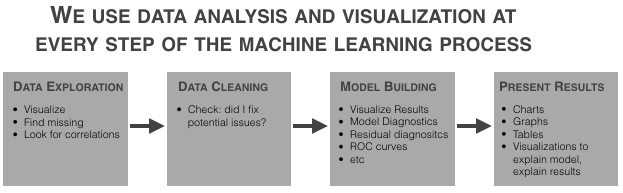

## 1. Inport necessary libraries

In [330]:
import pandas as pd
import numpy as np                       ## package for matrix..
import matplotlib.pyplot as plt          #Plot.
import matplotlib
import time,datetime

from pykalman import KalmanFilter
from tqdm import tqdm                    # Progress bar

from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (12, 5)
pd.options.mode.chained_assignment = None  # default='warn', use this with care

In [387]:
import math
import time,datetime

from sklearn.metrics import r2_score

from scipy.optimize import minimize

In [331]:
font = {'family' : 'normal',
        'weight':'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## 2. Data Processing

In [332]:
dat_DF = pd.read_csv('.\Data\Amita\Berg_All.csv')

C:\Users\ff9708\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.1.EDA

In [333]:
dat_DF.tail()

,Unix Time (s),Local Time,ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,ouCompressorCurrent,...,SH Smooth,Count,Baseline_SC,σ,Fault_1,Fault_2,CFM,Persistence1,Persistence2,Counter
160716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [334]:
h,l = dat_DF.shape
print(h,l)

160721 62


#### 1) Count NAN 

In [335]:
Nan_Count = {}
for column in dat_DF:
    Nan_Count[column] = [dat_DF[column].count(),dat_DF[column].count()/h]

In [336]:
Nan_Count = {column:[dat_DF[column].count(),dat_DF[column].count()/h] }
Nan_Count_WithMissing  = {column:[dat_DF[column].count(),dat_DF[column].count()/h] for column in dat_DF if dat_DF[column].count()/h<1}

In [337]:
### Find a period when no missing value is observation
# After in-depth check, I found after Row 43892.
dat_DF_2 = dat_DF.iloc[43892:,:]  #
h2,l2 = dat_DF_2.shape


Nan_Count_2 = {column:[dat_DF_2[column].count(),dat_DF_2[column].count()/h2] for column in dat_DF_2}
Nan_Count_2 = {column:[dat_DF_2[column].count(),dat_DF_2[column].count()/h2] for column in dat_DF_2 if dat_DF_2[column].count()/h2<1}

In [338]:
dat_DF_2['iuDAT'][dat_DF_2['iuDAT'].isna()]

120686   NaN
156100   NaN
156101   NaN
156102   NaN
156103   NaN
          ..
160716   NaN
160717   NaN
160718   NaN
160719   NaN
160720   NaN
Name: iuDAT, Length: 4622, dtype: float64

In [340]:
## Only one missing value for iuDAT
# Apply linear interpolation to it. 

#before Interpolate
ind_Na = dat_DF_2['iuDAT'].isna()

ind_Na_Int = dat_DF_2.index[ind_Na]

print('Before interpolation:\n{}'.format(dat_DF_2['iuDAT'][ind_Na]))  ##

#
#dat_DF_2['iuDAT_filled'] = dat_DF_2['iuDAT'].fillna(method='bfill').fillna(method='ffill') # This does not work....

dat_DF_2.loc[:,'iuDAT_filled'] = dat_DF_2.loc[:,'iuDAT'].copy()

dat_DF_2.loc[ind_Na_Int,'iuDAT_filled'] = (dat_DF_2['iuDAT'].fillna(method='bfill')[ind_Na] + 
                                    dat_DF_2['iuDAT'].fillna(method='ffill')[ind_Na])/2
print('\nAfter interpolation:\n{}'.format(dat_DF_2['iuDAT_filled'][ind_Na]))

Before interpolation:
120686   NaN
156100   NaN
156101   NaN
156102   NaN
156103   NaN
          ..
160716   NaN
160717   NaN
160718   NaN
160719   NaN
160720   NaN
Name: iuDAT, Length: 4622, dtype: float64

After interpolation:
120686    62.15
156100      NaN
156101      NaN
156102      NaN
156103      NaN
          ...  
160716      NaN
160717      NaN
160718      NaN
160719      NaN
160720      NaN
Name: iuDAT_filled, Length: 4622, dtype: float64


#### 2)Outliers -- Placeholder

#### 3)Numerical data distribution

C:\Users\ff9708\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ff9708\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([65814.,     0., 26003.,  9494., 32212., 11002.,  4283.,  3753.,
         2262.,  1225.]),
 array([   0. ,  200.7,  401.4,  602.1,  802.8, 1003.5, 1204.2, 1404.9,
        1605.6, 1806.3, 2007. ]),
 <a list of 10 Patch objects>)

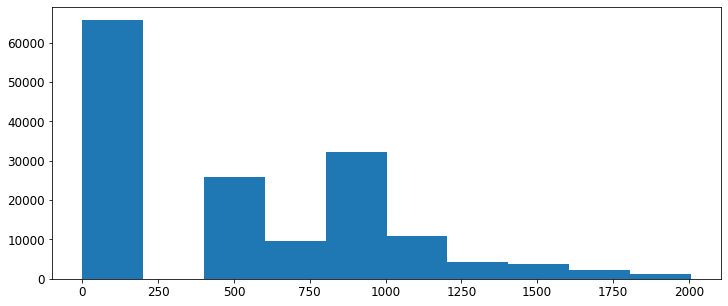

In [341]:
plt.hist(dat_DF['iuAirFlowRate'])

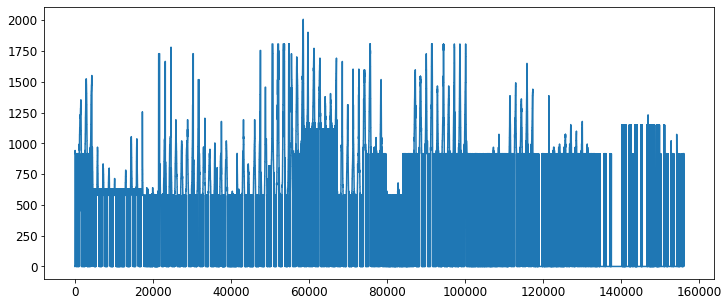

In [342]:
plt.plot(dat_DF['iuAirFlowRate'])

#### 4) **Data Transformation**
Calculate Sensible capcity
$$Cap_{sensible} = SpecHeat \times \rho \times Flowrate(T_{return} -T_{supply})$$
Where,$SpecHeat = 0.241Btu/Lb\ F^o$, $\rho = 0.074887 lbm/ft^3$

In [343]:
def cal_SensibleCap(dat_DF): 
    h,l = dat_DF.shape
    dat_DF['SensibleCapacity'] = dat_DF['iuAirFlowRate']  # Just define a new columns to store Sensible Capacity
    rho = 0.074887
    SpecHeat = 0.241

    for i in tqdm(range(h)):
        dat_DF['SensibleCapacity'].iloc[i] = dat_DF['iuAirFlowRate'].iloc[i] *SpecHeat * rho * 60 *(
                                                 dat_DF['tabTsense0'].iloc[i] - dat_DF['iuDAT'].iloc[i])
    return dat_DF

In [293]:
dat_DF_2 =  cal_SensibleCap(dat_DF_2)

100%|████████████████████████████████████████████████████████████████████████| 116829/116829 [00:51<00:00, 2256.19it/s]


In [344]:
dat_DF_Truncated = dat_DF_2.iloc[:66714,:]  #dat_DF_Truncated will be used as the main dataset in the following section

In [347]:
dat_DF_Truncated.head()

,Unix Time (s),Local Time,ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,ouCompressorCurrent,...,Count,Baseline_SC,σ,Fault_1,Fault_2,CFM,Persistence1,Persistence2,Counter,iuDAT_filled
43892,1.531389e+09,7/12/18 4:54,0.0,80.4,0.0,74.1,54.0,74.676505,75.061364,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.5
43893,1.531389e+09,7/12/18 4:55,0.0,79.6,0.0,74.1,54.0,75.012050,75.198137,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.3
43894,1.531389e+09,7/12/18 4:56,0.0,79.2,0.0,74.1,54.0,75.161585,75.280482,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.4
43895,1.531389e+09,7/12/18 4:57,0.0,79.0,577.0,74.0,54.0,76.854074,66.670983,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.6
43896,1.531389e+09,7/12/18 4:58,33.0,79.3,577.0,73.9,54.5,86.507454,47.798319,10.578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.3


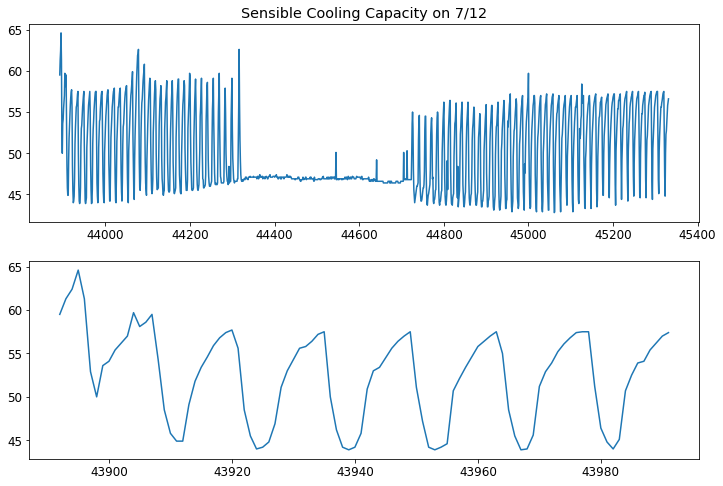

In [348]:
## a Preliminary viz
plt.figure(figsize = [12,8])

ax = plt.subplot(2,1,1)  ## setting 

plt.plot(dat_DF_Truncated.index[:1440],dat_DF_Truncated.iloc[:1440,-1])
ax.set_title("Sensible Cooling Capacity on 7/12")


plt.subplot(2,1,2)
plt.plot(dat_DF_Truncated.index[:100],dat_DF_Truncated.iloc[:100,-1])

#### 5) Abnormality
**First:** There are some observations when compressor is turned off while indoor air flow rate is greater than 0

In [349]:
idx_Ab1 = (dat_DF_Truncated["ouPresentCompressorFreq"] == 0 ) & (dat_DF_Truncated["iuAirFlowRate"] > 0 )

In [350]:
idx_Ab1

43892     False
43893     False
43894     False
43895      True
43896     False
          ...  
110601    False
110602    False
110603     True
110604    False
110605    False
Length: 66714, dtype: bool

#### 6) Aggregate data

In [351]:
import datetime,time

In [352]:
# read data
DF_Org_temp = pd.read_csv(r".\Data\Amita\data4kf_2.csv",date_parser = lambda x:time.strftime("%m/%d/%Y %H:%M",time.strptime(x,"%m/%d/%Y %H:%M")),
                    parse_dates = [2],index_col = [0])

In [300]:
DF_Org_temp.head()

,Unix Time (s),Local Time,ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,ouCompressorCurrent,...,Persistence2,Counter,iuDAT_filled,SensibleCapacity,Predicted Comp. Power,Actual Comp. Power,IDWB,Predict Sensible Capacity,ST_Ratio,Predict Comp. Power from Compressor Map
43892,1531389240,2018-07-12 04:54:00,0,80.4,0,74.1,54.0,74.676505,75.061364,0.000,...,0,0,59.5,0.000000,0.000000,0.000,62.989692,0,0,0.000000
43893,1531389300,2018-07-12 04:55:00,0,79.6,0,74.1,54.0,75.012050,75.198137,0.000,...,0,0,61.3,0.000000,0.000000,0.000,62.989692,0,0,0.000000
43894,1531389360,2018-07-12 04:56:00,0,79.2,0,74.1,54.0,75.161585,75.280482,0.000,...,0,0,62.4,0.000000,0.000000,0.000,62.989692,0,0,0.000000
43895,1531389420,2018-07-12 04:57:00,0,79.0,577,74.0,54.0,76.854074,66.670983,0.000,...,0,0,64.6,0.000000,0.000000,0.000,62.905096,0,0,0.000000
43896,1531389480,2018-07-12 04:58:00,33,79.3,577,73.9,54.5,86.507454,47.798319,10.578,...,0,0,61.3,7872.652539,1515.464186,1657.102,62.956721,18008,0,1635.621587


### <span style = "color:red">Data is not continuous !!!</spane>

In [353]:
DF_Org = DF_Org_temp
DF_Org = DF_Org.set_index('Local Time')

In [354]:
## aggregate without filling the missing values
DF_Org_15T = DF_Org.resample("15T").mean() #sum()
DF_Org_5T = DF_Org.resample("5T").mean()
DF_Org_hr = DF_Org.resample("60T").mean()

sum(DF_Org_15T['Actual Comp. Power'].isnull()),sum(DF_Org_5T['Actual Comp. Power'].isnull()),sum(DF_Org_hr['Actual Comp. Power'].isnull())

(424, 1275, 105)

In [355]:
#aggregate data and fill missing values using bfill.(Ideally, interpolation is better. However, Python does not have a
# built-in interpolatio for this. )
DF_Org_15T = DF_Org.resample("15T").mean().bfill()
DF_Org_5T = DF_Org.resample("5T").mean().bfill()
DF_Org_hr = DF_Org.resample("60T").mean().bfill()

Text(0.5, 1.0, "['Hourly']")

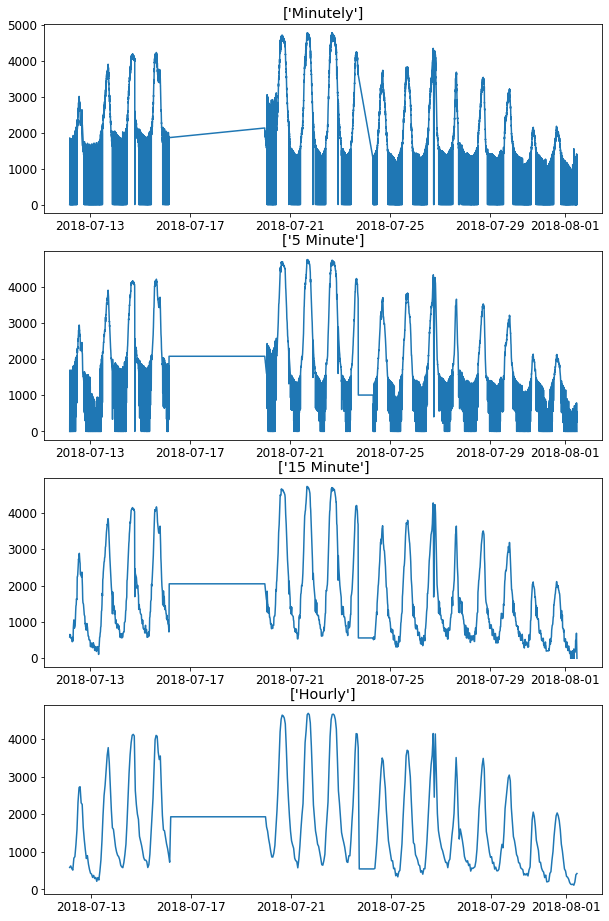

In [356]:
plt.figure(figsize = [10,16])

ax = plt.subplot(4,1,1)
plt.plot(DF_Org["Actual Comp. Power"])
ax.set_title(["Minutely"])

ax = plt.subplot(4,1,2)
plt.plot(DF_Org_5T["Actual Comp. Power"])
ax.set_title(["5 Minute"])

ax = plt.subplot(4,1,3)
plt.plot(DF_Org_15T["Actual Comp. Power"])
ax.set_title(["15 Minute"])

ax = plt.subplot(4,1,4)
plt.plot(DF_Org_hr["Actual Comp. Power"])
ax.set_title(["Hourly"])


## 3. **Curving fitting based on CoolTool outputs**

### 3.1. Enumerate Conditions

This part is used to enumerate Sysim input in order to fully exciting the units

In [357]:
import psychrolib as psy
psy.SetUnitSystem(psy.IP)

import itertools

In [358]:
IDDB_list = np.arange(65,81,5)
ODDB_list = np.arange(60,120,10)
RH_list = np.arange(30,80,10)

Ind_list = []

for iddb in IDDB_list:
    for rh in RH_list:
        idwb = psy.CalcPsychrometricsFromRelHum(iddb,rh/100,14.96)[1]
        Ind_list.append([iddb,idwb])

Out_list = []
for oddb in ODDB_list:
    for rh in RH_list:
        odwb = psy.CalcPsychrometricsFromRelHum(oddb,rh/100,14.96)[1]
        Out_list.append([oddb,odwb])
        
Cond_Enum = []
for i in itertools.product(Ind_list,Out_list):
    Cond_Enum.append(i[0] + i[1])

In [359]:
Speed_List = [60,40,30]
Ind_Flowrate = [1800,1190,930]
Out_Flowrate = [4240,3596,3026]
temp , temp2 = [], []
for i in itertools.product(Speed_List,Ind_Flowrate,Out_Flowrate):
    temp.append(i)
    
for i in itertools.product(temp,Cond_Enum):
    temp2.append(list(i[0]) + i[1])

In [251]:
Cond_Enum = temp2
Cond_Enum_DF = pd.DataFrame(Cond_Enum,columns = ("Speed","Ind_Flowrate","Out_Flowrate","IDDB","IDWB","ODDB","ODWB"))

Cond_Enum_DF.to_csv(".\data\Cond_Enum2.csv")

### 3.2. Curve fitting

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [253]:
## Read Sysim simulation result 
dat_CoolTool = pd.read_csv('.\Data\Amita\CoolTool_Result.csv',index_col = [0])

In [254]:
# Generate new feature
h,l = dat_CoolTool.shape
dat_CoolTool["Speed_sq"] = dat_CoolTool["Speed"].apply(lambda x:x*x)
dat_CoolTool["Ind_Flowrate_sq"] = dat_CoolTool["Ind_Flowrate"].apply(lambda x:x*x)
dat_CoolTool["Out_Flowrate_sq"] = dat_CoolTool["Out_Flowrate"].apply(lambda x:x*x)
dat_CoolTool["IDDB_sq"] = dat_CoolTool["IDDB"].apply(lambda x:x*x)
dat_CoolTool["IDWB_sq"] = dat_CoolTool["IDWB"].apply(lambda x:x*x)

dat_CoolTool["ODDB_sq"] = dat_CoolTool["ODDB"].apply(lambda x:x*x)
dat_CoolTool["ODWB_sq"] = dat_CoolTool["ODWB"].apply(lambda x:x*x)

dat_CoolTool["Suct Temp_sq"] = dat_CoolTool["Suct Temp"].apply(lambda x:x*x)
dat_CoolTool["Liq Temp_sq"] = dat_CoolTool["Liq Temp"].apply(lambda x:x*x)

dat_CoolTool["Lid_Suct_Temp"] = dat_CoolTool["Liq Temp_sq"]
    

In [255]:
for i in np.arange(h):
    dat_CoolTool["Lid_Suct_Temp"].iloc[i] = dat_CoolTool["Liq Temp"].iloc[i] *dat_CoolTool["Suct Temp"].iloc[i]

#### 1) Sensible Cap **Feature_Set2**

In [256]:
dat_CoolTool.head()

,Speed,Ind_Flowrate,Out_Flowrate,IDDB,IDWB,ODDB,ODWB,Liq Temp,Suct Temp,Net S/T,...,Speed_sq,Ind_Flowrate_sq,Out_Flowrate_sq,IDDB_sq,IDWB_sq,ODDB_sq,ODWB_sq,Suct Temp_sq,Liq Temp_sq,Lid_Suct_Temp
Numer,,,,,,,,,,,,,,,,,,,,,
1,60,1800,4240,65,49.498393,60,45.878054,65.215,46.522,0.998,...,3600,3240000,17977600,4225,2450.090959,3600,2104.795831,2164.296484,4252.996225,3033.932230
2,60,1800,4240,65,49.498393,60,48.137144,65.207,46.521,0.998,...,3600,3240000,17977600,4225,2450.090959,3600,2317.184652,2164.203441,4251.952849,3033.494847
3,60,1800,4240,65,49.498393,60,50.306796,65.199,46.521,0.998,...,3600,3240000,17977600,4225,2450.090959,3600,2530.773727,2164.203441,4250.909601,3033.122679
4,60,1800,4240,65,49.498393,60,52.393946,65.191,46.520,0.998,...,3600,3240000,17977600,4225,2450.090959,3600,2745.125547,2164.110400,4249.866481,3032.685320
5,60,1800,4240,65,49.498393,60,54.401233,65.184,46.520,0.998,...,3600,3240000,17977600,4225,2450.090959,3600,2959.494188,2164.110400,4248.953856,3032.359680


In [257]:
dat_CoolTool.columns

Index(['Speed', 'Ind_Flowrate', 'Out_Flowrate', 'IDDB', 'IDWB', 'ODDB', 'ODWB',
       'Liq Temp', 'Suct Temp', 'Net S/T', 'S/T', 'Sensible Capacity',
       'Total Capacity', 'Total Watt', 'Comp. Watt', 'Unnamed: 16',
       'Unnamed: 17', 'Speed_sq', 'Ind_Flowrate_sq', 'Out_Flowrate_sq',
       'IDDB_sq', 'IDWB_sq', 'ODDB_sq', 'ODWB_sq', 'Suct Temp_sq',
       'Liq Temp_sq', 'Lid_Suct_Temp'],
      dtype='object')

In [258]:
feature_Set_1 = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB"]

In [259]:
feature_Set = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB",
              "Speed_sq","Ind_Flowrate_sq","IDDB_sq","IDWB_sq","ODDB_sq","Liq Temp","Suct Temp"]
feature_Set_All = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB",
              "Speed_sq","Ind_Flowrate_sq","IDDB_sq","IDWB_sq","ODDB_sq","Liq Temp","Suct Temp",'Sensible Capacity']

In [260]:
dat_LR = dat_CoolTool[feature_Set_1]
dat_LR.shape
dat_LR = dat_LR.drop_duplicates()
dat_LR.shape

(1080, 5)

In [261]:
dat_LR = dat_CoolTool[feature_Set]
dat_LR.shape
dat_LR = dat_LR.drop_duplicates()
dat_LR.shape

(16137, 12)

In [262]:
dat_LR = dat_CoolTool[feature_Set_All]
dat_LR.shape
dat_LR = dat_LR.drop_duplicates()
dat_LR.shape

(16200, 13)

In [263]:
dat_LR = dat_LR.iloc[np.random.permutation(dat_LR.shape[0]),:] 

In [264]:
Train_Test_ratio = 5

#Prepare train and test data
X = dat_LR[feature_Set_1]
Y = dat_LR["Sensible Capacity"]

h,l = X.shape

X_Train = X.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1)),:]
X_Test = X.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):,:]

Y_Train = Y.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1))]
Y_Test = Y.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):]

#training model
reg_SC = LinearRegression()

reg_SC = reg_SC.fit(X_Train,Y_Train)

reg_SC.score(X_Train,Y_Train),reg_SC.coef_, reg_SC.intercept_

(0.9602418694129865,
 array([  344.02462998,    10.15483635,  1151.7644192 , -1123.8153435 ,
          -82.34026249]),
 -6699.046725944019)

In [265]:
## Model R2 score on testing dataset
Y_Pred_Train = reg_SC.predict(X_Train)

r2_score(Y_Pred_Train,Y_Train)

0.9585957123372275

In [266]:
## Model R2 score on testing dataset
reg_SC.score(X_Test,Y_Test)

Y_Pred = reg_SC.predict(X_Test)

r2_score(Y_Pred,Y_Test)

0.9571378059399659

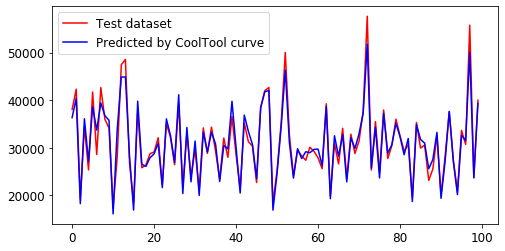

In [267]:
plt.figure(figsize = [8,4])
ax = plt.subplot(1,1,1)
plt.plot(np.arange(100),Y_Test[:100],"r")

#plt.figure(figsize = [12,6])
plt.plot(np.arange(100),Y_Pred[:100],'b')

ax.legend(['Test dataset','Predicted by CoolTool curve'])

#### 2) Net S/T. **Feature_Set2**

In [146]:
Train_Test_ratio = 5

feature_Set = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB"] #Best  


#Prepare train and test data
X = dat_CoolTool[feature_Set]
Y = dat_CoolTool["Net S/T"]

h,l = X.shape

X_Train = X.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1)),:]
X_Test = X.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):,:]

Y_Train_ST = Y.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1))]
Y_Test_ST = Y.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):]

#training model
reg_ST = LinearRegression()
reg_ST = reg_ST.fit(X_Train,Y_Train_ST)

reg_ST.score(X_Train,Y_Train_ST),reg_ST.coef_, reg_ST.intercept_

(0.9603785416070059,
 array([-0.00301901,  0.00011665,  0.02532964, -0.03695427,  0.00099038]),
 1.0702966735324102)

In [147]:
## Model R2 score on testing dataset
Y_Pred_Train = reg_ST.predict(X_Train)

r2_score(Y_Pred_Train,Y_Train_ST)

0.958743915366231

In [148]:
## Model R2 score on testing dataset
reg_ST.score(X_Test,Y_Test_ST)

Y_Pred_ST = reg_ST.predict(X_Test)

r2_score(Y_Pred,Y_Test_ST)

-17.41290064422261

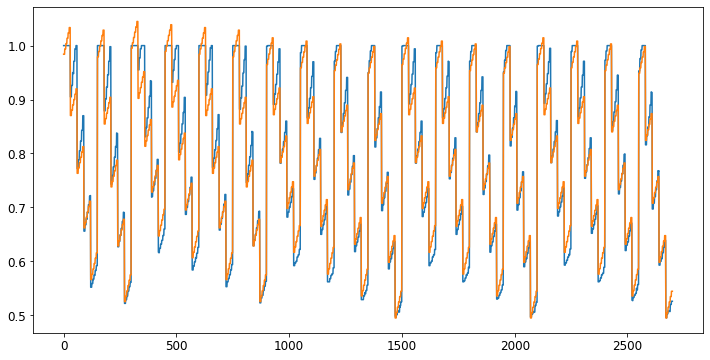

In [149]:
plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_ST)),Y_Test_ST)

#plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_ST)),Y_Pred_ST)

#### 3) Capacity. **Feature_Set2**

In [150]:
Train_Test_ratio = 5

feature_Set = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB"] #Best  


#Prepare train and test data
X = dat_CoolTool[feature_Set]
Y_TC = dat_CoolTool["Total Capacity"]

h,l = X.shape

X_Train = X.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1)),:]
X_Test = X.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):,:]

Y_Train_TC = Y_TC.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1))]
Y_Test_TC = Y_TC.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):]

#training model
reg_TC = LinearRegression()
reg_TC = reg_TC.fit(X_Train,Y_Train_TC)

reg_TC.score(X_Train,Y_Train_TC),reg_TC.coef_, reg_TC.intercept_

(0.9757906059243316,
 array([ 606.89227673,    7.66286647,  241.16761459,  395.57389297,
        -163.05220848]),
 -25153.310161659792)

In [151]:
Y_Pred_Train = reg_TC.predict(X_Train)

r2_score(Y_Pred_Train,Y_Train_TC)

0.9751899701342835

In [152]:
## Model R2 score on testing dataset
reg_TC.score(X_Test,Y_Test_TC)

Y_Pred_TC = reg_TC.predict(X_Test)

r2_score(Y_Pred_TC,Y_Test_TC)

0.9283515869043771

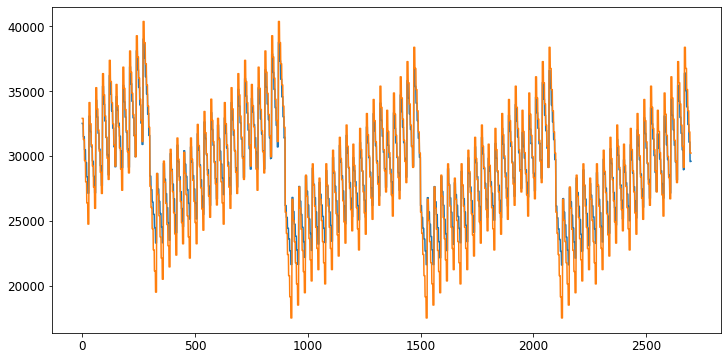

In [153]:
plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_TC)),Y_Test_TC)

#plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_TC)),Y_Pred_TC)

#### 4) Power. **Feature_Set2**

In [154]:
feature_Set = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB"] #Best  

In [155]:
Train_Test_ratio = 5

#Prepare train and test data
X = dat_CoolTool[feature_Set]
Y = dat_CoolTool["Comp. Watt"]

h,l = X.shape

X_Train = X.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1)),:]
X_Test = X.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):,:]

Y_Train_Power = Y.iloc[:int(h*Train_Test_ratio/(Train_Test_ratio+1))]
Y_Test_Power = Y.iloc[int(h*Train_Test_ratio/(Train_Test_ratio+1)):]

#training model
reg_Power = LinearRegression()
reg_Power = reg_Power.fit(X_Train,Y_Train_Power)

reg_Power.score(X_Train,Y_Train_Power),reg_Power.coef_, reg_Power.intercept_

(0.9766533660802587,
 array([6.76671708e+01, 5.73014903e-02, 4.27750468e-01, 2.75789578e+00,
        3.43163237e+01]),
 -3677.138713521811)

In [156]:
Y_Pred_Train = reg_Power.predict(X_Train)

r2_score(Y_Pred_Train,Y_Train_Power)

0.9760952711262937

In [157]:
## Model R2 score on testing dataset
reg_Power.score(X_Test,Y_Test_Power)

Y_Pred_Power = reg_Power.predict(X_Test)

r2_score(Y_Pred_Power,Y_Test_Power)

0.9125784735338658

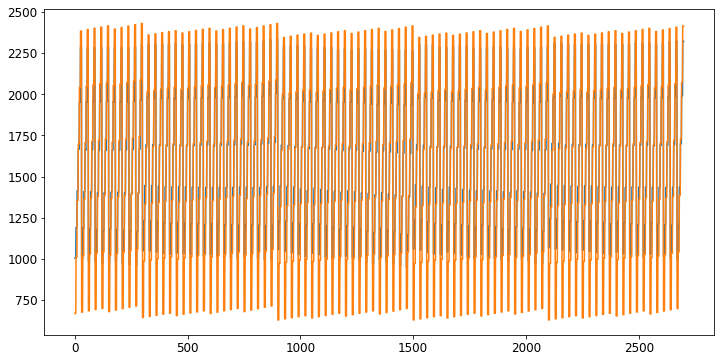

In [158]:
plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_Power)),Y_Test_Power)

#plt.figure(figsize = [12,6])
plt.plot(np.arange(len(Y_Test_Power)),Y_Pred_Power)

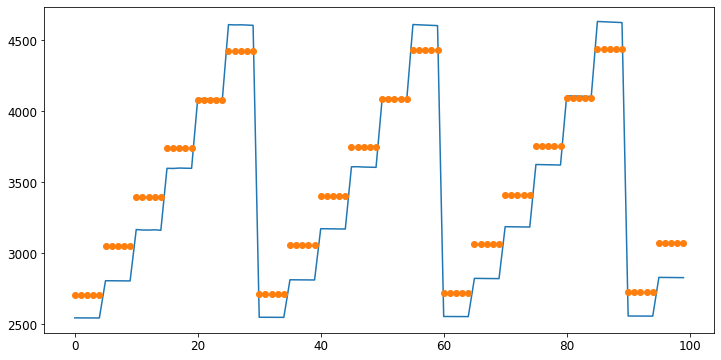

In [159]:
plt.figure(figsize = [12,6])
plt.plot(np.arange(100),Y_Train_Power[:100])

#plt.figure(figsize = [12,6])
plt.plot(np.arange(100),Y_Pred_Train[:100],'o')

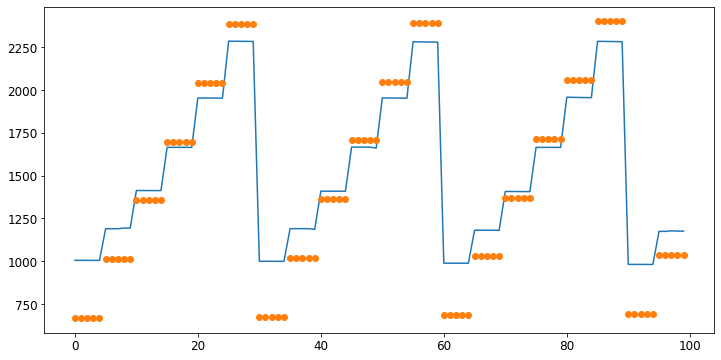

In [160]:
plt.figure(figsize = [12,6])
plt.plot(np.arange(100),Y_Test_Power[:100])

#plt.figure(figsize = [12,6])
plt.plot(np.arange(100),Y_Pred_Power[:100],'o')

### 3.3. Testing for fitted curve

In [361]:
dat_DF_Truncated.to_csv(".\Data\Amita\data4kf.csv")

In [362]:
dat_DF = pd.read_csv(".\Data\Amita\data4kf.csv",index_col = [0])

In [363]:
dat_DF.head()

,Unix Time (s),Local Time,ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,ouCompressorCurrent,...,Count,Baseline_SC,σ,Fault_1,Fault_2,CFM,Persistence1,Persistence2,Counter,iuDAT_filled
43892,1.531389e+09,7/12/18 4:54,0.0,80.4,0.0,74.1,54.0,74.676505,75.061364,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.5
43893,1.531389e+09,7/12/18 4:55,0.0,79.6,0.0,74.1,54.0,75.012050,75.198137,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.3
43894,1.531389e+09,7/12/18 4:56,0.0,79.2,0.0,74.1,54.0,75.161585,75.280482,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.4
43895,1.531389e+09,7/12/18 4:57,0.0,79.0,577.0,74.0,54.0,76.854074,66.670983,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.6
43896,1.531389e+09,7/12/18 4:58,33.0,79.3,577.0,73.9,54.5,86.507454,47.798319,10.578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.3


In [364]:
dat_DF["IDWB"] = dat_DF["iuAirFlowRate"]
for i in tqdm(np.arange(dat_DF.shape[0])):
    dat_DF["IDWB"].iloc[i] = psy.CalcPsychrometricsFromRelHum(dat_DF["tabTsense0"].iloc[i],
                                                                     dat_DF["humidityIndoor.0"].iloc[i]/100,14.96)[1]

 85%|███████████████████████████████████████████████████████████████▏          | 56914/66714 [00:19<00:03, 2952.97it/s]C:\Users\ff9708\Anaconda3\lib\site-packages\psychrolib.py:1461: RuntimeWarning: invalid value encountered in GetHumRatioFromRelHum
  HumRatio = GetHumRatioFromRelHum(TDryBulb, RelHum, Pressure)
C:\Users\ff9708\Anaconda3\lib\site-packages\psychrolib.py:1462: RuntimeWarning: invalid value encountered in GetTWetBulbFromHumRatio
  TWetBulb = GetTWetBulbFromHumRatio(TDryBulb, HumRatio, Pressure)
C:\Users\ff9708\Anaconda3\lib\site-packages\psychrolib.py:1463: RuntimeWarning: invalid value encountered in GetTDewPointFromHumRatio
  TDewPoint = GetTDewPointFromHumRatio(TDryBulb, HumRatio, Pressure)
C:\Users\ff9708\Anaconda3\lib\site-packages\psychrolib.py:1464: RuntimeWarning: invalid value encountered in GetVapPresFromHumRatio
  VapPres = GetVapPresFromHumRatio(HumRatio, Pressure)
C:\Users\ff9708\Anaconda3\lib\site-packages\psychrolib.py:1465: RuntimeWarning: invalid value enc

In [365]:
# Generate new feature
dat_DF["Speed_sq"] = dat_DF["ouPresentCompressorFreq"].apply(lambda x:float(x)*float(x))
dat_DF["ID Flowrate_sq"] = dat_DF["iuAirFlowRate"].apply(lambda x:float(x)*float(x))
dat_DF["IDDB_sq"] = dat_DF["tabTsense0"].apply(lambda x:float(x)*float(x))
dat_DF["IDWB_sq"] = dat_DF["IDWB"].apply(lambda x:float(x)*float(x))

dat_DF["ODDB_sq"] = dat_DF["ouTemperatureOutdoor"].apply(lambda x:float(x)*float(x))


#### 1) Sensible Cap. **Feature_Set2**

In [366]:
dat_DF = cal_SensibleCap(dat_DF)

100%|██████████████████████████████████████████████████████████████████████████| 66714/66714 [00:18<00:00, 3694.03it/s]


In [367]:
def Pred_SensibleCap(DFrame,reg,featureset):
    ##Predict
    DFrame["Predict Sensible Capacity"] = DFrame["iuAirFlowRate"].copy() # Create a placeholder for the predicted values

    On_Idx,Off_Idx  = DFrame["ouPresentCompressorFreq"]>0 , DFrame["ouPresentCompressorFreq"]==0

    # When compressor is off
    DFrame["Predict Sensible Capacity"][Off_Idx] = 0
    DFrame["SensibleCapacity"][Off_Idx] = 0
    #When compressor is on
    DFrame["Predict Sensible Capacity"][On_Idx] = reg.predict(DFrame[On_Idx][featureset])
     
    return DFrame

In [368]:
feature_Set_Test  = ["ouPresentCompressorFreq","iuAirFlowRate","tabTsense0","IDWB","ouTemperatureOutdoor"]#,
              #"Speed_sq","ID Flowrate_sq","IDDB_sq","IDWB_sq","ODDB_sq","Liq. T..1","Suc. T..1"]

In [369]:
dat_DF = Pred_SensibleCap(dat_DF,reg_SC,feature_Set_Test)

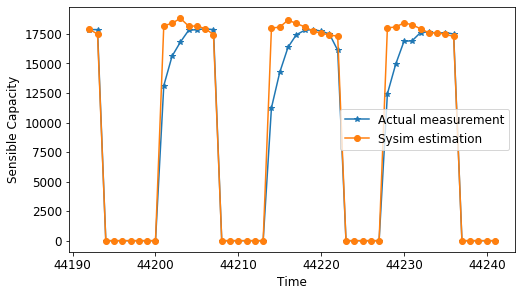

In [370]:
#Visualize result
plt.figure(figsize = [8,4.5])
ax = plt.subplot(1,1,1)
plt.plot(dat_DF['SensibleCapacity'].iloc[300:350],'-*')
plt.plot(dat_DF["Predict Sensible Capacity"].iloc[300:350],"-o")
ax.set_ylabel('Sensible Capacity')
ax.set_xlabel('Time')
ax.legend(['Actual measurement','Sysim estimation'])

Text(0.5, 0, '')

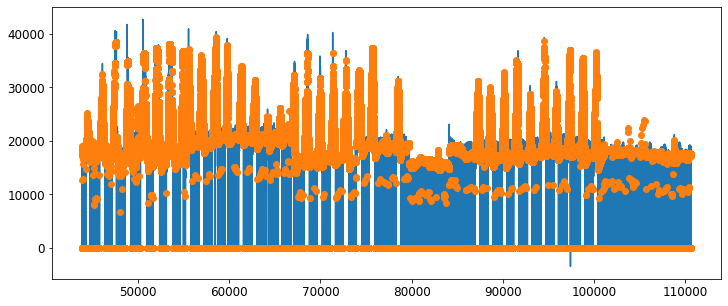

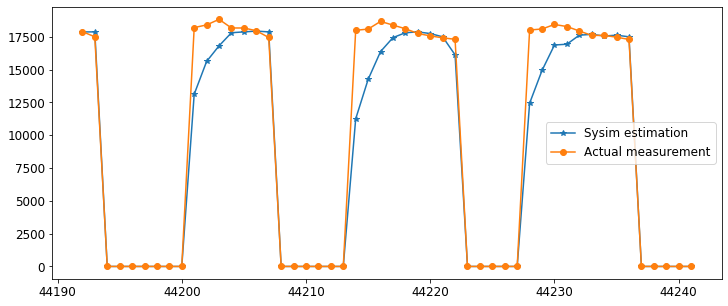

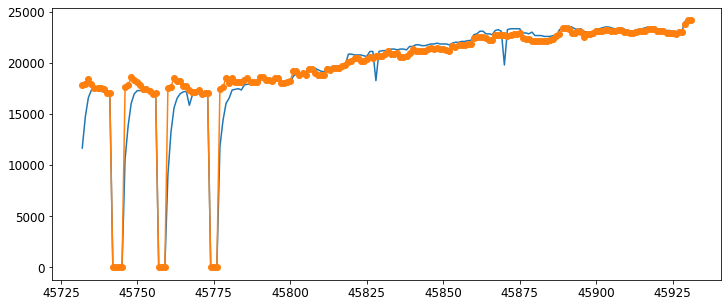

In [371]:
#Visualize result
plt.figure()
plt.plot(dat_DF['SensibleCapacity'])
plt.plot(dat_DF["Predict Sensible Capacity"],"o")

plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(dat_DF['SensibleCapacity'].iloc[300:350],'-*')
plt.plot(dat_DF["Predict Sensible Capacity"].iloc[300:350],"-o")
ax.set_xlabel('')
ax.legend(['Sysim estimation','Actual measurement'])

#Visualize result
plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(dat_DF['SensibleCapacity'].iloc[1840:2040])
plt.plot(dat_DF["Predict Sensible Capacity"].iloc[1840:2040],"-o")
ax.set_xlabel('')

In [372]:
dat_DF.to_csv(r'.\Data\Amita\minute_SC.csv')

#### 2) Power **Feature_Set2**

In [373]:
#feature_Set = ["Speed","Ind_Flowrate","IDDB","IDWB","ODDB"] #Best 
feature_Set_Test = ["ouPresentCompressorFreq","iuAirFlowRate","tabTsense0","IDWB","ouTemperatureOutdoor"]

##Predict
dat_DF["Predicted Comp. Power"] = dat_DF["iuAirFlowRate"].copy() # Create a placeholder for the predicted values
dat_DF["Actual Comp. Power"] = dat_DF["iuAirFlowRate"].copy() # Create a placeholder for the predicted values


In [374]:
for i in range(dat_DF.shape[0]):
    dat_DF['Actual Comp. Power'].iloc[i] = dat_DF['ouInputCurrent'].iloc[i] * dat_DF['ouInputVoltage'].iloc[i]  

In [375]:
On_Idx, Off_Idx = dat_DF["ouPresentCompressorFreq"]>0, dat_DF["ouPresentCompressorFreq"]==0

# When compressor is off
dat_DF["Predicted Comp. Power"][Off_Idx] = 0
dat_DF["Actual Comp. Power"][Off_Idx] = 0

#When compressor is on
dat_DF["Predicted Comp. Power"][On_Idx] = reg_Power.predict(dat_DF[On_Idx][feature_Set_Test])

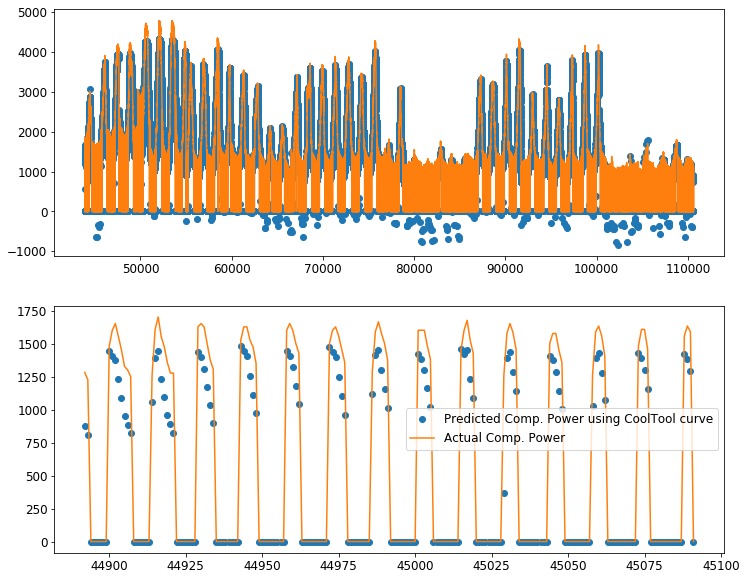

In [379]:
#Visualize result
plt.figure(figsize = [12,10])
ax = plt.subplot(2,1,1)
plt.plot(dat_DF["Predicted Comp. Power"],'o')
plt.plot(dat_DF["Actual Comp. Power"])

ax = plt.subplot(2,1,2)
plt.plot(dat_DF["Predicted Comp. Power"].iloc[1000:1200],'o')
plt.plot(dat_DF["Actual Comp. Power"].iloc[1000:1200])
ax.legend(["Predicted Comp. Power using CoolTool curve",'Actual Comp. Power'])

In [384]:
r2_score(dat_DF["Predicted Comp. Power"],dat_DF["Actual Comp. Power"])

0.9766667584971229

In [385]:
dat_DF.to_csv(r'.\Data\Amita\minute.csv')

In [386]:
#Save to csv file
DF_Org_15T.to_csv(r'.\Data\Amita\15minute.csv')
DF_Org_5T.to_csv(r'.\Data\Amita\5minute.csv')
DF_Org_hr.to_csv(r'.\Data\Amita\hourly.csv')
dat_DF.to_csv(r'.\Data\Amita\minute.csv')

## 4. KFilter Model

In [388]:
DF_Org = pd.read_csv(r'.\Data\Amita\minute_SC.csv',parse_dates = [2],index_col = [2])

In [389]:
DF_Org.head()

,Unnamed: 0,Unix Time (s),ouPresentCompressorFreq,ouTemperatureOutdoor,iuAirFlowRate,tabTsense0,humidityIndoor.0,Liq. T.,Suc. T.,ouCompressorCurrent,...,Counter,iuDAT_filled,IDWB,Speed_sq,ID Flowrate_sq,IDDB_sq,IDWB_sq,ODDB_sq,SensibleCapacity,Predict Sensible Capacity
Local Time,,,,,,,,,,,,,,,,,,,,,
2018-07-12 04:54:00,43892,1.531389e+09,0.0,80.4,0.0,74.1,54.0,74.676505,75.061364,0.000,...,0.0,59.5,62.989692,0.0,0.0,5490.81,3967.701242,6464.16,0.000000,0.000000
2018-07-12 04:55:00,43893,1.531389e+09,0.0,79.6,0.0,74.1,54.0,75.012050,75.198137,0.000,...,0.0,61.3,62.989692,0.0,0.0,5490.81,3967.701242,6336.16,0.000000,0.000000
2018-07-12 04:56:00,43894,1.531389e+09,0.0,79.2,0.0,74.1,54.0,75.161585,75.280482,0.000,...,0.0,62.4,62.989692,0.0,0.0,5490.81,3967.701242,6272.64,0.000000,0.000000
2018-07-12 04:57:00,43895,1.531389e+09,0.0,79.0,577.0,74.0,54.0,76.854074,66.670983,0.000,...,0.0,64.6,62.905096,0.0,332929.0,5476.00,3957.051073,6241.00,0.000000,0.000000
2018-07-12 04:58:00,43896,1.531389e+09,33.0,79.3,577.0,73.9,54.5,86.507454,47.798319,10.578,...,0.0,61.3,62.956721,1089.0,332929.0,5461.21,3963.548677,6288.49,7872.652539,18347.185743


In [7]:
def KFilter1(num,z,A,mu0,Sigma0,Phi,Ups,Gam,cQ,cR,inp):
    # Note: Must give cholesky decomp: cQ = np.linalg.choleske(Q),cR = np.linalg.choleske(R)
    Q = np.dot(cQ.T,cQ)
    R = np.dot(cR.T,cR)
    
    
    # z is num by q (time=row series=col) 
    # input is num by r (use 0 if not needed) 
    # A is an array with dim=c(q,p,num)
    # Ups is p by r (use 0 if not needed) Gam is q by r (use 0 if not needed)
    # R is q by q 
    # mu0 is p by 1 
    # Sigma0, Phi, Q are p by p,   Constant.
    Phi,z,inp = np.array(Phi),np.array(z), np.array(inp)
    pdim = Phi.shape[0]
    qdim = z.shape[1]  #
    rdim = inp.shape[1]  # 
    
    if np.max(np.abs(Ups)) == 0:
        Ups = np.zeros((pdim,rdim))
    if np.max(np.abs(Gam)) == 0:
        Gam = np.zeros((qdim,rdim))
    
    xp, xf = np.zeros([num,pdim,1]), np.zeros([num,pdim,1])  # Store the results
    Pp,Pf = np.zeros([num,pdim,pdim]), np.zeros([num,pdim,pdim])
    innov,sig = np.zeros([num,qdim,1]), np.zeros([num,qdim,qdim]) # Innovations, and the covariance matrix
    
    # Initialize
    x0,Sigma0 = np.array(mu0),np.array(Sigma0)
    xp[0] = np.dot(Phi,mu0) + np.dot(Ups,inp[0]) 
    Pp[0] = np.dot(np.dot(Phi, Sigma0),Phi.T) + Q
    
    A_cur = A[0]
    sigtemp = np.dot(np.dot(A_cur,Pp[0]),A_cur.T) + R
    sig[0] = (sigtemp.T +sigtemp) / 2
    
    sigInv = np.linalg.inv(sig[0])
    
    K = np.dot(np.dot(Pp[0], A_cur.T), sigInv)
    innov[0] = z[0] - np.dot(A_cur,xp[0]) - np.dot(Gam,inp[0])
    
    ## update
    xf[0] = xp[0] + np.dot(K,innov[0])
    Pf[0] = Pp[0] - np.dot(np.dot(K,A_cur),Pp[0])
    
    den = (1/np.sqrt(np.linalg.det(sig[0]))/(2*math.pi)**.5)
    if den == 0:
        den = den+10**(-300)
        print('Zer0 Encountered')
    like = -np.log(den) -( -.5 * np.dot(np.dot(innov[0].T,sigInv),innov[0]))  #-log(Likelihood)
    
    for i in range(1,num):
        xp[i] = np.dot(Phi,xf[i-1]) + np.dot(Ups,inp[i])
        Pp[i] = np.dot(np.dot(Phi, Pf[i-1]),Phi.T) + Q
        
        A_cur = A[i]
        sigtemp = np.dot(np.dot(A_cur,Pp[i]),A_cur.T) + R
        sig[i] = (sigtemp.T +sigtemp) / 2

        sigInv = np.linalg.inv(sig[i])

        K = np.dot(np.dot(Pp[i], A_cur.T), sigInv)
        innov[i] = z[i] - np.dot(A_cur,xp[i]) - np.dot(Gam,inp[i])

        ## update
        xf[i] = xp[i] + np.dot(K,innov[i])
        Pf[i] = Pp[i] - np.dot(np.dot(K,A_cur),Pp[i])
           
        den = (1/np.sqrt(np.linalg.det(sig[i]))/(2*math.pi)**.5)
        like = like - np.log(den) -( -.5 * np.dot(np.dot(innov[i].T,sigInv),innov[i])) #-log(Likelihood), very small zero!!!
    # Output
    re = {}
    re['like'] = like
    re['xp'] = xp
    re['xf'] = xf
    re['Pp'] = Pp
    re['Pf'] = Pf
    re['innov'] = innov
    re['Sig'] = sig          
           
    return re

### 4.1. Kalman Filter Model For Sensible Capacity

$$x_k = Fx_{k-1} + Bu_k +w_{k}$$
$$z_k = Hx_{k} + v_{k}$$

$$x_k = Phi x_{k-1} + Ups u_k +cQ_{k}$$
$$z_k = A x_{k} + cR_{k}$$  This is used in function KFilter1

**x: Actual Sensible Capacity, z: Predicted Sensible via CoolTool; H = 1**

Time series data first.

Variable speed:Power is known, cap.. 

Fixed speed: Both power and cap is unknown, 

In [390]:
on_idx = DF_Org['SensibleCapacity'] >0
off_idx = DF_Org['SensibleCapacity'] ==0
transient_idx =  off_idx.shift(1) & on_idx

In [398]:
DF_Org['const'] = DF_Org['SensibleCapacity']
DF_Org['const'] = 1

#### Dynamic observation matrics

In [391]:
def KFilter1_Revised(num,z,A1,A2,A3,Conds,mu0,Sigma0,Phi,Ups,Gam,cQ,cR,inp):
    # Note: Must give cholesky decomp: cQ = np.linalg.choleske(Q),cR = np.linalg.choleske(R)
    Q = np.dot(cQ.T,cQ)
    R = np.dot(cR.T,cR)
    
    
    # z is num by q (time=row series=col) 
    # input is num by r (use 0 if not needed) 
    # A is an array with dim=c(q,p,num)
    # Ups is p by r (use 0 if not needed) Gam is q by r (use 0 if not needed)
    # R is q by q 
    # mu0 is p by 1 
    # Sigma0, Phi, Q are p by p,   Constant.
    Phi,z,inp = np.array(Phi),np.array(z), np.array(inp)
    pdim = Phi.shape[0]
    qdim = z.shape[1]  #
    rdim = inp.shape[1]  # 
    
    if np.max(np.abs(Ups)) == 0:
        Ups = np.zeros((pdim,rdim))
    if np.max(np.abs(Gam)) == 0:
        Gam = np.zeros((qdim,rdim))
    
    xp, xf = np.zeros([num,pdim,1]), np.zeros([num,pdim,1])  # Store the results
    Pp,Pf = np.zeros([num,pdim,pdim]), np.zeros([num,pdim,pdim])
    innov,sig = np.zeros([num,qdim,1]), np.zeros([num,qdim,qdim]) # Innovations, and the covariance matrix
    
    # Initialize
    x0,Sigma0 = np.array(mu0),np.array(Sigma0)
    xp[0] = np.dot(Phi,mu0) + np.dot(Ups,inp[0]) 
    Pp[0] = np.dot(np.dot(Phi, Sigma0),Phi.T) + Q
        
    if Conds[0] == 1:
        A_cur = A1[0]
    elif Conds[0] == 2:
        A_cur = A2[0]
    else:
        A_cur = A3[0]
        
    sigtemp = np.dot(np.dot(A_cur,Pp[0]),A_cur.T) + R
    sig[0] = (sigtemp.T +sigtemp) / 2
    
    sigInv = np.linalg.inv(sig[0])
    
    K = np.dot(np.dot(Pp[0], A_cur.T), sigInv)
    innov[0] = z[0] - np.dot(A_cur,xp[0]) - np.dot(Gam,inp[0])
    
    ## update
    xf[0] = xp[0] + np.dot(K,innov[0])
    Pf[0] = Pp[0] - np.dot(np.dot(K,A_cur),Pp[0])
    try:
        den = (1/np.sqrt(np.linalg.det(sig[0]))/(2*math.pi)**.5)
    except:
        print(0,sig[0])
    if den == 0:
        den = den+10**(-300)
        print('Zer0 Encountered')
    like = -np.log(den) -( -.5 * np.dot(np.dot(innov[0].T,sigInv),innov[0]))  #-log(Likelihood)
    
    for i in range(1,num):
        xp[i] = np.dot(Phi,xf[i-1]) + np.dot(Ups,inp[i])
        Pp[i] = np.dot(np.dot(Phi, Pf[i-1]),Phi.T) + Q
        
        if Conds[i] == 1:
            A_cur = A1[i]
        elif Conds[i] == 2:
            A_cur = A2[i]
        else:
            A_cur = A3[i]
            
        sigtemp = np.dot(np.dot(A_cur,Pp[i]),A_cur.T) + R
        sig[i] = (sigtemp.T +sigtemp) / 2
        try:
            sigInv = np.linalg.inv(sig[i])
        except:
            print(i,'inv',sig[i])
        K = np.dot(np.dot(Pp[i], A_cur.T), sigInv)
        innov[i] = z[i] - np.dot(A_cur,xp[i]) - np.dot(Gam,inp[i])

        ## update
        xf[i] = xp[i] + np.dot(K,innov[i])
        Pf[i] = Pp[i] - np.dot(np.dot(K,A_cur),Pp[i])
        try:
            den = (1/np.sqrt(np.linalg.det(sig[i]))/(2*math.pi)**.5)
        except:
            print(sig[i])
        if den== 0 :
            den += 10**(-300)
        like = like - np.log(den) -( -.5 * np.dot(np.dot(innov[i].T,sigInv),innov[i])) #-log(Likelihood), very small zero!!!
    # Output
    re = {}
    re['like'] = like
    re['xp'] = xp
    re['xf'] = xf
    re['Pp'] = Pp
    re['Pf'] = Pf
    re['innov'] = innov
    re['Sig'] = sig          
           
    return re

##### 1) Dynamic, no input, offset

In [392]:
z_train = np.reshape(np.array(DF_Org['SensibleCapacity'].iloc[1:1440]),[-1,1])
nrow = len(z_train)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp =np.reshape(np.array([1]*nrow),[-1,1,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0


mu0 = np.array([[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]])
sigma0 = np.eye(2)
# Function to Calculate Likelihood
def linn_test(par): 
    Phi = np.eye(2)
    Phi[0,0] = par[0]
    Phi[1,1] = 0 #par[1]
    
    cQ = np.eye(2)
    cQ[0,0] =  par[1]
    cQ[1,1] =  par[2]
    
    cR = np.array([[par[3]]])
    
    Ups = np.zeros((2,1))
    Ups[0,0] = par[4]
    Ups[1,0] = par[5]

    #print(Ups, inp[0],np.dot(Ups,inp[0]))
    kf = KFilter1_Revised(nrow,z_train,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

In [393]:
init_par = [1,  0.1, 0.1, 0.1,1,1]

In [394]:
linn_test(init_par)

array([[2.75449046e+11]])

In [395]:
bnds = ((None, None), (0.01, None),(0.01, None),(0.01, None),(None, None),(None, None))
#bound
res = minimize(linn_test,init_par,method = 'L-BFGS-B',bounds = bnds)

KeyboardInterrupt: 

In [ ]:
Phi = np.eye(2)
Phi[0,0] = res['x'][0]
Phi[1,1] = 0 #par[1]

cQ = np.eye(2)
cQ[0,0] =  res['x'][1]
cQ[1,1] =  res['x'][2]

cR = np.array([[np.std(DF_Org['SensibleCapacity'] - DF_Org['Predict Sensible Capacity'])]])

Ups = np.zeros((2,1))
Ups[0,0] = res['x'][4]
Ups[1,0] = res['x'][5]

z_test = np.reshape(np.array(DF_Org['Predict Sensible Capacity'].iloc[1:1440]),[-1,1])
nrow = len(z_test)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp =np.reshape(np.array([1]*nrow),[-1,1,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

#print(Ups, inp[0],np.dot(Ups,inp[0]))
kf = KFilter1_Revised(nrow,z_test,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)

In [ ]:
y = [0] *len(Conds)
for i,cond in enumerate(Conds):
    if cond == 1:
        #print(cond)
        y[i] = kf['xf'][i,0]
    elif cond == 2:
        #print(cond)
        y[i] = kf['xf'][i,1]
    else:
        y[i] = 0
        

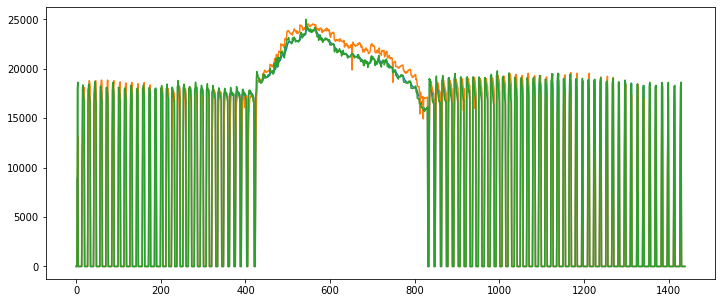

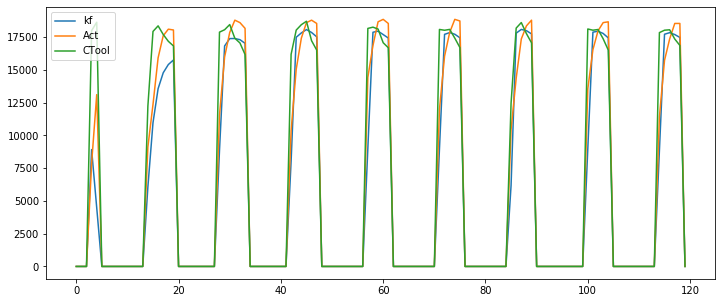

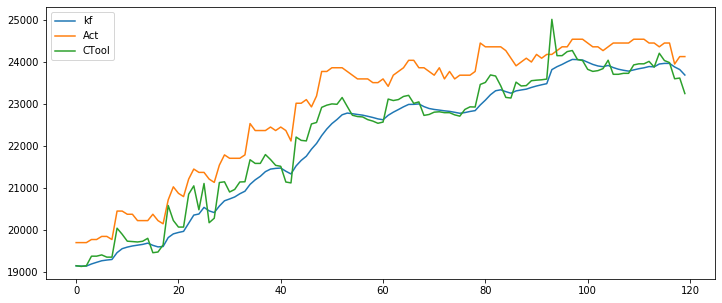

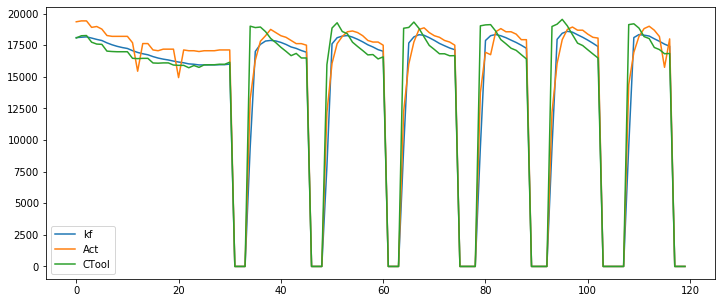

In [827]:
plt.plot(y)
plt.plot(np.arange(nrow),DF_Org['SensibleCapacity'].iloc[1:1440])
plt.plot(np.arange(nrow),DF_Org['Predict Sensible Capacity'].iloc[1:1440])

plt.figure()
ax = plt.subplot()
plt.plot(y[:120])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[1:121])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[1:121])
ax.legend(['kf','Act','CTool'])

plt.figure()
ax = plt.subplot()
plt.plot(y[450:570])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[451:571])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[451:571])
ax.legend(['kf','Act','CTool'])

plt.figure()
ax = plt.subplot()
plt.plot(y[800:920])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[801:921])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[801:921])
ax.legend(['kf','Act','CTool'])

##### 2) Dynamic, 2 input, offset

In [396]:
z_train = np.reshape(np.array(DF_Org['SensibleCapacity'].iloc[1:1440]),[-1,1])
nrow = len(z_train)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp =np.reshape(np.array([1]*nrow),[-1,1,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0


mu0 = np.array([[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]])
sigma0 = np.eye(2)
# Function to Calculate Likelihood
def linn_test(par): 
    Phi = np.eye(2)
    Phi[0,0] = par[0]
    Phi[1,1] = 0 #par[1]
    
    cQ = np.eye(2)
    cQ[0,0] =  par[1]
    cQ[1,1] =  par[2]
    
    cR = np.array([[par[3]]])
    
    Ups = np.zeros((2,1))
    Ups[0,0] = par[4]
    Ups[1,0] = par[5]

    #print(Ups, inp[0],np.dot(Ups,inp[0]))
    kf = KFilter1_Revised(nrow,z_train,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

In [399]:
z_train = np.reshape(np.array(DF_Org['SensibleCapacity'].iloc[1:1440]),[-1,1])
nrow = len(z_train)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp = np.reshape(np.array(DF_Org[['ouTemperatureOutdoor','tabTsense0','const']].iloc[1:1440]),[-1,3,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0


mu0 = [[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood
def linn_test(par): 
    Phi = np.eye(2)
    Phi[0,0] = par[0]
    Phi[1,1] = 0 # par[1]
    
    cQ = np.eye(2)
    cQ[0,0] =  par[1]
    cQ[1,1] =  par[2]
    
    cR = np.array([[par[3]]])
    
    Ups = np.zeros((2,3))
    Ups[0,0] = par[4]
    Ups[0,1] = par[5]
    Ups[0,2] = par[6]
    
    Ups[1,0] = par[7]
    Ups[1,1] = par[8]
    Ups[1,2] = par[9]

    #print(Ups, inp[0],np.dot(Ups,inp[0]))
    kf = KFilter1_Revised(nrow,z_train,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

In [400]:
init_par = [1,.1,.1,.1,1,1,1,1,1,1]
linn_test(init_par)

array([[2.70471505e+11]])

In [123]:
bnds = ((None, None), (0.01, None),(0.01, None),(0.01, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None))
#bound
res = minimize(linn_test,init_par,method = 'L-BFGS-B',bounds = bnds)

In [128]:
res

      fun: array([[11572.82922548]])
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10965630e+01, -3.86717147e-01, -2.01362127e-01,  4.50745574e-01,
       -5.42604539e+00, -4.96202119e+00, -6.54836185e-02, -3.38695827e-01,
       -8.04720912e-01, -1.03682396e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 814
      nit: 59
   status: 0
  success: True
        x: array([  0.98272706, 328.58015361, 506.38372446, 651.00049509,
         3.12128887,   0.89986184,   1.00646524,  79.14402205,
        72.71795513,   1.96924353])

In [774]:
Phi = np.eye(2)
Phi[0,0] = res['x'][0]
Phi[1,1] = 0 #par[1]

cQ = np.eye(2)
cQ[0,0] =  res['x'][1]
cQ[1,1] =  res['x'][2]

cR = np.array([[np.std(DF_Org['SensibleCapacity'] - DF_Org['Predict Sensible Capacity'])]])

Ups = np.zeros((2,3))
Ups[0,0] = res['x'][4]
Ups[0,1] = res['x'][5]
Ups[0,2] = res['x'][6]

Ups[1,0] = res['x'][7]
Ups[1,1] = res['x'][8]
Ups[1,2] = res['x'][9]

z_test = np.reshape(np.array(DF_Org['Predict Sensible Capacity'].iloc[1:1440]),[-1,1])
nrow = len(z_test)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp = np.reshape(np.array(DF_Org[['ouTemperatureOutdoor','tabTsense0','const']].iloc[1:1440]),[-1,3,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

#print(Ups, inp[0],np.dot(Ups,inp[0]))
kf = KFilter1_Revised(nrow,z_test,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)

In [775]:
y = [0] *len(Conds)
for i,cond in enumerate(Conds):
    if cond == 1:
        #print(cond)
        y[i] = kf['xf'][i,0]
    elif cond == 2:
        #print(cond)
        y[i] = kf['xf'][i,1]
    else:
        y[i] = 0
        

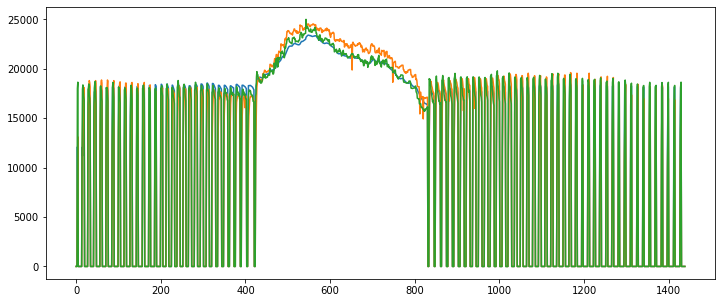

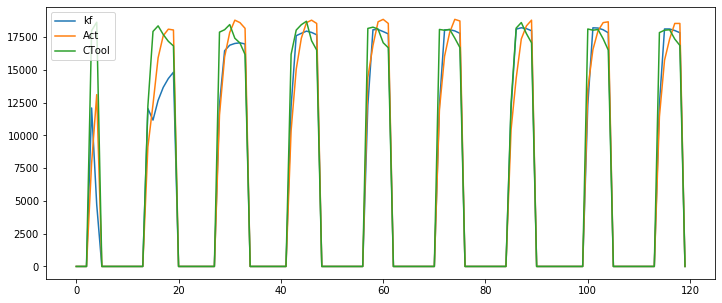

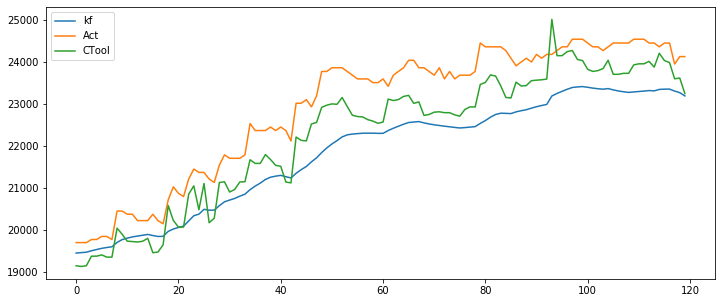

In [776]:
plt.plot(y)
plt.plot(np.arange(nrow),DF_Org['SensibleCapacity'].iloc[1:1440])
plt.plot(np.arange(nrow),DF_Org['Predict Sensible Capacity'].iloc[1:1440])

plt.figure()
ax = plt.subplot()
plt.plot(y[:120])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[1:121])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[1:121])
ax.legend(['kf','Act','CTool'])

plt.figure()
ax = plt.subplot()
plt.plot(y[450:570])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[451:571])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[451:571])
ax.legend(['kf','Act','CTool'])

##### 3) Dynamic, 5 input, offset

In [402]:
z_train = np.reshape(np.array(DF_Org['SensibleCapacity'].iloc[1:1440]),[-1,1])

nrow = len(z_train)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp = np.reshape(np.array(DF_Org[['ouPresentCompressorFreq','ouTemperatureOutdoor','iuAirFlowRate','tabTsense0','humidityIndoor.0','const']].iloc[1:1440]),[-1,6,1])

## Idx is used to determine the unit mode: on, off, transition period. 
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])

Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

## Initial value for x
mu0 = [[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]]
sigma0 = np.eye(2)

# Function to Calculate Likelihood
def linn_test(par): 
    Phi = np.eye(2)
    Phi[0,0] = par[0]
    Phi[1,1] = 0 # par[1]
    
    cQ = np.eye(2)
    cQ[0,0] =  par[1]
    cQ[1,1] =  par[2]
    
    cR = np.array([[par[3]]])
    
    Ups = np.zeros((2,6))
    Ups[0,0] = par[4]
    Ups[0,1] = par[5]
    Ups[0,2] = par[6]
    Ups[0,3] = par[7]
    Ups[0,4] = par[8]
    Ups[0,5] = par[9]
    
    Ups[1,0] = par[10]
    Ups[1,1] = par[11]
    Ups[1,2] = par[12]
    Ups[1,3] = par[13]
    Ups[1,4] = par[14]
    Ups[1,5] = par[15]

    #print(Ups, inp[0],np.dot(Ups,inp[0]))
    kf = KFilter1_Revised(nrow,z_train,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

In [403]:
init_par = [1,.1,.1,.1,1,1,1,1,1,1,1,1,1,1,1,1]
linn_test(init_par)

array([[2.70910403e+11]])

In [97]:
bnds = ((None, None), (0.01, None),(0.01, None),(0.01, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None)
       ,(None, None),(None, None),(None, None),(None, None),(None, None),(None, None))
#bound
res = minimize(linn_test,init_par,method = 'L-BFGS-B',bounds = bnds)

KeyboardInterrupt: 

In [136]:
res

      fun: array([[11440.36131741]])
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.68868462e+01, -1.70985004e-02, -1.28238753e-01,  1.36788003e-01,
        7.55608198e-01,  1.83063094e+00, -1.06010702e+00, -1.54232112e+00,
       -9.87711246e-01, -2.11002771e-02, -4.42742021e-01,  2.26282282e-01,
       -1.79898052e-01, -3.00133252e-02,  2.72848411e-02, -3.63797881e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2380
      nit: 99
   status: 0
  success: True
        x: array([-3.14263237e-01,  1.19577240e+02,  5.26330524e+02,  6.80214966e+02,
       -1.98876022e-01,  1.36288199e+01,  3.39062168e+01,  2.08871885e+01,
        1.67815806e+01,  1.27893946e+00,  4.63332383e+00,  2.07177333e+00,
        1.94722697e+01,  3.41339453e+00,  2.43310954e+00,  1.03584410e+00])

In [405]:
res = {'k':0}

In [406]:
res['x'] = [-3.14263237e-01,  1.19577240e+02,  5.26330524e+02,  6.80214966e+02,
       -1.98876022e-01,  1.36288199e+01,  3.39062168e+01,  2.08871885e+01,
        1.67815806e+01,  1.27893946e+00,  4.63332383e+00,  2.07177333e+00,
        1.94722697e+01,  3.41339453e+00,  2.43310954e+00,  1.03584410e+00]

In [407]:
Phi = np.eye(2)
Phi[0,0] = res['x'][0]
Phi[1,1] = 0 #par[1]

cQ = np.eye(2)
cQ[0,0] =  res['x'][1]
cQ[1,1] =  res['x'][2]

cR = np.array([[np.std(DF_Org['SensibleCapacity'] - DF_Org['Predict Sensible Capacity'])]])

Ups = np.zeros((2,6))
Ups[0,0] = res['x'][4]
Ups[0,1] = res['x'][5]
Ups[0,2] = res['x'][6]
Ups[0,3] = res['x'][7]
Ups[0,4] = res['x'][8]
Ups[0,5] = res['x'][9]

Ups[1,0] = res['x'][10]
Ups[1,1] = res['x'][11]
Ups[1,2] = res['x'][12]
Ups[1,3] = res['x'][13]
Ups[1,4] = res['x'][14]
Ups[1,5] = res['x'][15]

z_test = np.reshape(np.array(DF_Org['Predict Sensible Capacity'].iloc[1:2881]),[-1,1])
nrow = len(z_test)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

mu0 = [[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]]
inp = np.reshape(np.array(DF_Org[['ouPresentCompressorFreq','ouTemperatureOutdoor','iuAirFlowRate','tabTsense0','humidityIndoor.0','const']].iloc[1:2881]),[-1,6,1])

idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

#print(Ups, inp[0],np.dot(Ups,inp[0]))
kf = KFilter1_Revised(nrow,z_test,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)

In [408]:
idx1 = np.array(transient_idx.iloc[1:2881])
idx2 = np.array(off_idx.iloc[1:2881])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0
### calculate predicted Z
y = [0] *len(Conds)
for i,cond in enumerate(Conds):
    if cond == 1:
        #print(cond)
        y[i] = kf['xf'][i,0]
    elif cond == 2:
        #print(cond)
        y[i] = kf['xf'][i,1]
    else:
        y[i] = 0
        

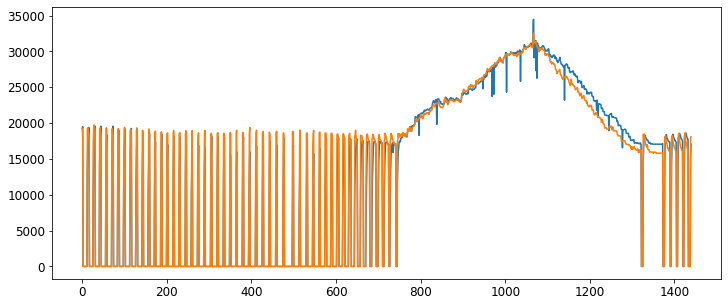

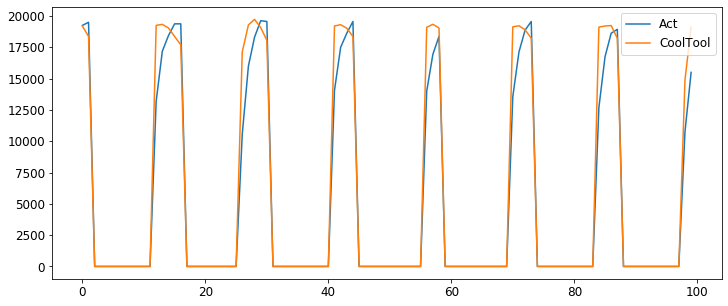

In [409]:

plt.plot(np.arange(2580-1140),DF_Org['SensibleCapacity'].iloc[1140:2580])
plt.plot(np.arange(2580-1140),DF_Org['Predict Sensible Capacity'].iloc[1140:2580])

plt.figure()
ax =plt.subplot(1,1,1)
plt.plot(np.arange(100),DF_Org['SensibleCapacity'].iloc[1140:1240])
plt.plot(np.arange(100),DF_Org['Predict Sensible Capacity'].iloc[1140:1240])
ax.legend(['Act',"CoolTool"])

In [410]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14

C:\Users\ff9708\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


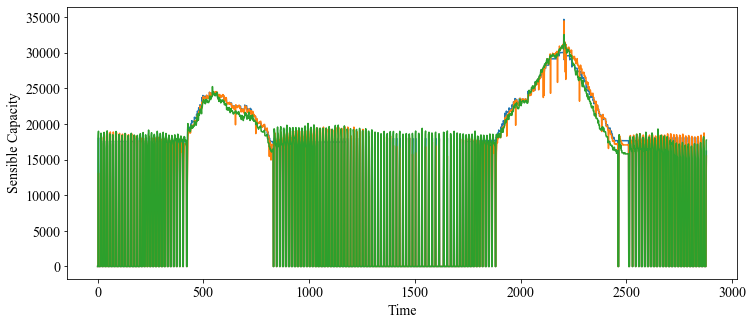

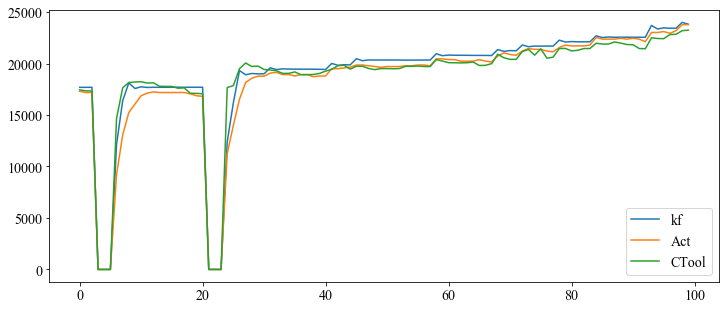

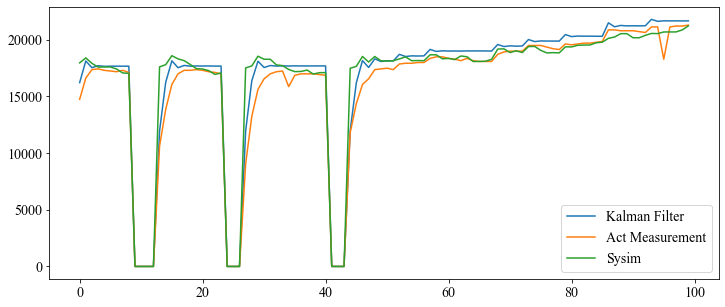

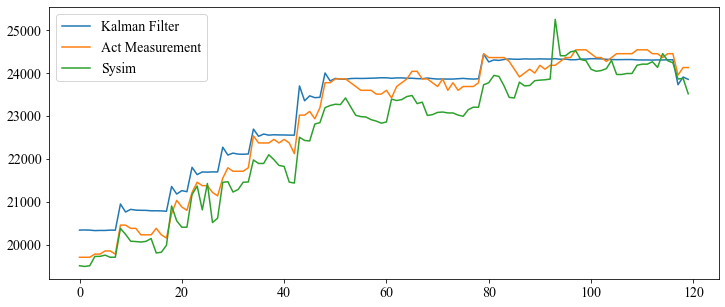

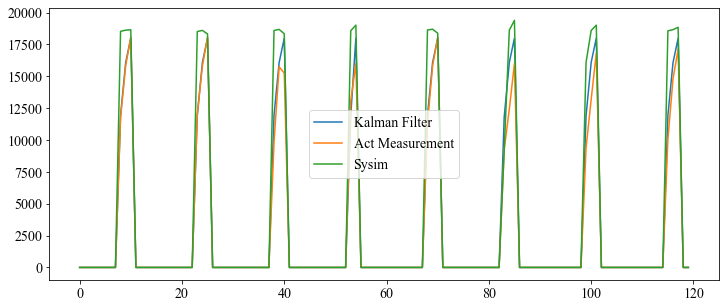

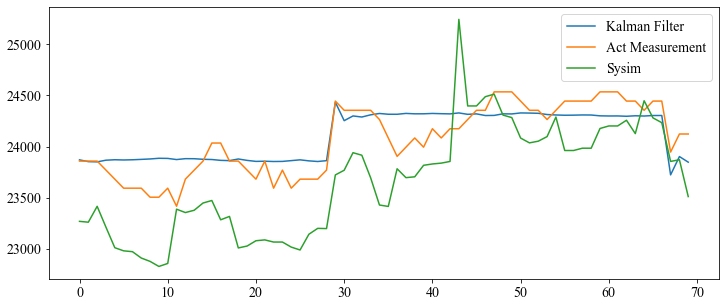

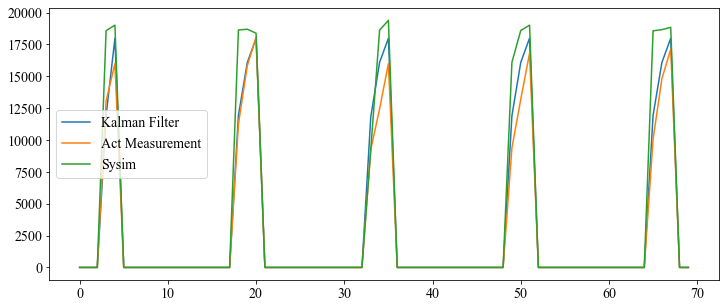

In [411]:
plt.plot(y)
ax = plt.subplot(1,1,1)
plt.plot(np.arange(nrow),DF_Org['SensibleCapacity'].iloc[1:2881])
plt.plot(np.arange(nrow),DF_Org['Predict Sensible Capacity'].iloc[1:2881])
ax.set_xlabel('Time')
ax.set_ylabel('Sensible Capacity')


plt.figure()
ax = plt.subplot()
plt.plot(y[400:500])
plt.plot(np.arange(100),DF_Org['SensibleCapacity'].iloc[401:501])
plt.plot(np.arange(100),DF_Org['Predict Sensible Capacity'].iloc[401:501])
ax.legend(['kf','Act','CTool'])


plt.figure()
ax = plt.subplot()
plt.plot(y[1840:1940])
plt.plot(np.arange(100),DF_Org['SensibleCapacity'].iloc[1841:1941])
plt.plot(np.arange(100),DF_Org['Predict Sensible Capacity'].iloc[1841:1941])
ax.legend(['Kalman Filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[450:570])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[451:571])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[451:571])
ax.legend(['Kalman Filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[1450:1570])
plt.plot(np.arange(120),DF_Org['SensibleCapacity'].iloc[1451:1571])
plt.plot(np.arange(120),DF_Org['Predict Sensible Capacity'].iloc[1451:1571])
ax.legend(['Kalman Filter','Act Measurement','Sysim'])


plt.figure()
ax = plt.subplot()
plt.plot(y[500:570])
plt.plot(np.arange(70),DF_Org['SensibleCapacity'].iloc[501:571])
plt.plot(np.arange(70),DF_Org['Predict Sensible Capacity'].iloc[501:571])
ax.legend(['Kalman Filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[1500:1570])
plt.plot(np.arange(70),DF_Org['SensibleCapacity'].iloc[1501:1571])
plt.plot(np.arange(70),DF_Org['Predict Sensible Capacity'].iloc[1501:1571])
ax.legend(['Kalman Filter','Act Measurement','Sysim'])


In [412]:
Phi = np.eye(2)
Phi[0,0] = res['x'][0]
Phi[1,1] = 0 #par[1]

cQ = np.eye(2)
cQ[0,0] =  res['x'][1]
cQ[1,1] =  res['x'][2]

cR = np.array([[np.std(DF_Org['SensibleCapacity'] - DF_Org['Predict Sensible Capacity'])]])

Ups = np.zeros((2,6))
Ups[0,0] = res['x'][4]
Ups[0,1] = res['x'][5]
Ups[0,2] = res['x'][6]
Ups[0,3] = res['x'][7]
Ups[0,4] = res['x'][8]
Ups[0,5] = res['x'][9]

Ups[1,0] = res['x'][10]
Ups[1,1] = res['x'][11]
Ups[1,2] = res['x'][12]
Ups[1,3] = res['x'][13]
Ups[1,4] = res['x'][14]
Ups[1,5] = res['x'][15]

z_test = np.reshape(np.array(DF_Org['Predict Sensible Capacity'].iloc[1:1440*7+1]),[-1,1])
nrow = len(z_test)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

mu0 = [[DF_Org['SensibleCapacity'].iloc[0]],[DF_Org['SensibleCapacity'].iloc[0]]]
inp = np.reshape(np.array(DF_Org[['ouPresentCompressorFreq','ouTemperatureOutdoor','iuAirFlowRate','tabTsense0','humidityIndoor.0','const']].iloc[1:1440*7+1]),[-1,6,1])
idx1 = np.array(transient_idx.iloc[1:1440*7+1])
idx2 = np.array(off_idx.iloc[1:1440*7+1])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

#print(Ups, inp[0],np.dot(Ups,inp[0]))
kf = KFilter1_Revised(nrow,z_test,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)

In [413]:
idx1 = np.array(transient_idx.iloc[1:1440*7+1])
idx2 = np.array(off_idx.iloc[1:1440*7+1])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

y = [0] *len(Conds)
for i,cond in enumerate(Conds):
    if cond == 1:
        #print(cond)
        y[i] = kf['xf'][i,0]
    elif cond == 2:
        #print(cond)
        y[i] = kf['xf'][i,1]
    else:
        y[i] = 0
        

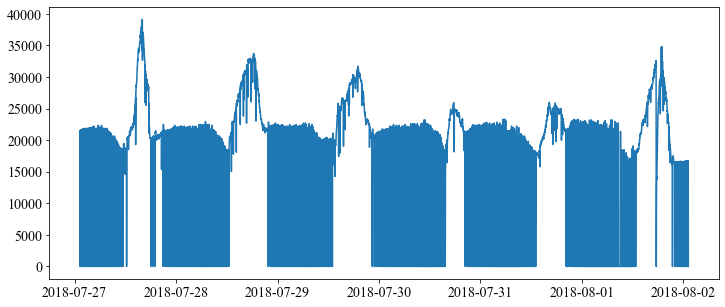

In [414]:
plt.plot(DF_Org['SensibleCapacity'].iloc[15000:15000+1440*6+1])

In [415]:
for i,yy in enumerate(y):
    if yy > 40000:
        y[i] = DF_Org['SensibleCapacity'].iloc[i+1]

C:\Users\ff9708\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[Text(0, 0, '7-12'),
 Text(0, 0, '7-13'),
 Text(0, 0, '7-14'),
 Text(0, 0, '7-15')]

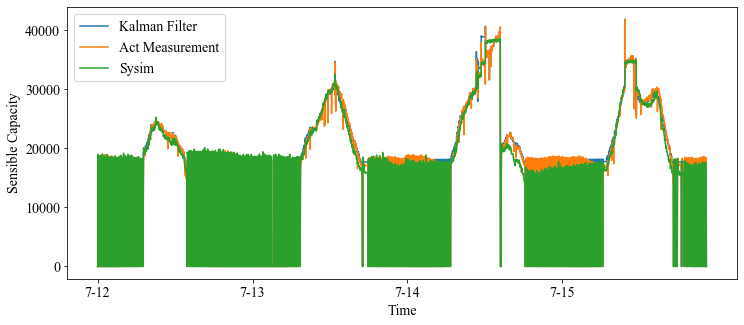

In [416]:
plt.plot(y[:5660])
ax = plt.subplot(1,1,1)
plt.plot(np.arange(5660),DF_Org['SensibleCapacity'].iloc[1:5661])
plt.plot(np.arange(5660),DF_Org['Predict Sensible Capacity'].iloc[1:5661])
ax.set_xlabel('Time')
ax.set_ylabel('Sensible Capacity')
ax.legend(['Kalman Filter','Act Measurement','Sysim'])
ax.set_xticks([0,1440,2880,1440*3])
ax.set_xticklabels(['7-12','7-13','7-14','7-15'])

In [418]:
DF_Org['KF Result'] = DF_Org['SensibleCapacity']
DF_Org['KF Result'].iloc[1:7101] = y[:7100]

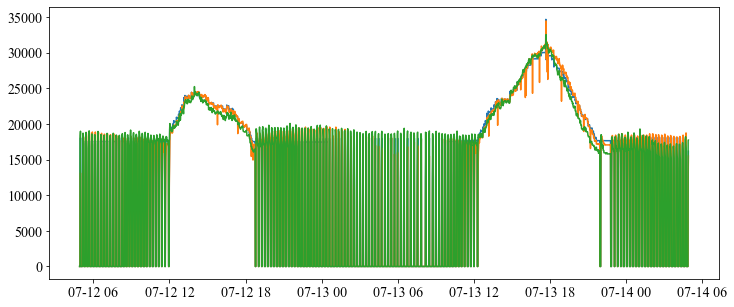

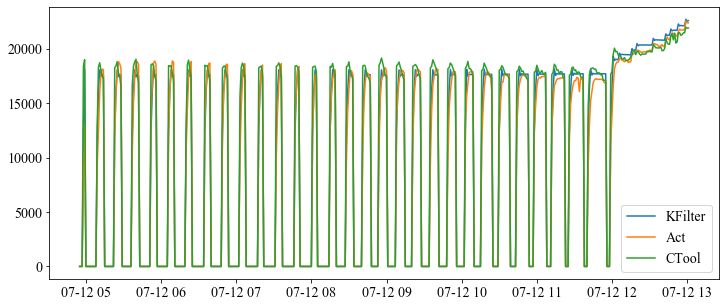

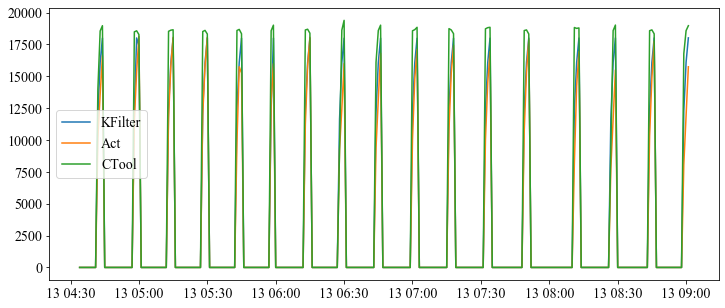

In [419]:
plt.plot(DF_Org['KF Result'].iloc[1:2881])
plt.plot(DF_Org['SensibleCapacity'].iloc[1:2881])
plt.plot(DF_Org['Predict Sensible Capacity'].iloc[1:2881])

plt.figure()
ax = plt.subplot()
plt.plot(DF_Org['KF Result'].iloc[1:488])
plt.plot(DF_Org['SensibleCapacity'].iloc[1:488])
plt.plot(DF_Org['Predict Sensible Capacity'].iloc[1:488])
ax.legend(['KFilter','Act','CTool'])

plt.figure()
ax = plt.subplot()
plt.plot(DF_Org['KF Result'].iloc[1420:1688])
plt.plot(DF_Org['SensibleCapacity'].iloc[1420:1688])
plt.plot(DF_Org['Predict Sensible Capacity'].iloc[1420:1688])
ax.legend(['KFilter','Act','CTool'])

In [420]:
# based on Hz Group
hz_under22 = DF_Org["ouPresentCompressorFreq"] <22
hz_22_30 = (DF_Org["ouPresentCompressorFreq"] >= 22) & (DF_Org["ouPresentCompressorFreq"]<30)
hz_30_40 = (DF_Org["ouPresentCompressorFreq"] >= 30) & (DF_Org["ouPresentCompressorFreq"]<40)
hz_40_50 = (DF_Org["ouPresentCompressorFreq"] >= 40) & (DF_Org["ouPresentCompressorFreq"]<50)
hz_50_60 = (DF_Org["ouPresentCompressorFreq"] >= 50) & (DF_Org["ouPresentCompressorFreq"] <60)
hz_above60 = (DF_Org["ouPresentCompressorFreq"] >= 60)
hz_idx = [hz_under22,hz_22_30, hz_30_40,hz_40_50,hz_50_60,hz_above60]

In [421]:
res1 = DF_Org["SensibleCapacity"].iloc[1:7101].copy()
res2 = DF_Org["SensibleCapacity"].iloc[1:7101].copy()

for i in range(7100):
    if DF_Org["SensibleCapacity"].iloc[i+1] == 0:
        res1.iloc[i] = 0
        res2.iloc[i] = 0
    else:
        res1.iloc[i] = abs(DF_Org["SensibleCapacity"].iloc[i+1] -DF_Org["KF Result"].iloc[i+1])/DF_Org["SensibleCapacity"].iloc[i+1]
        res2.iloc[i] = abs(DF_Org["SensibleCapacity"].iloc[i+1] -DF_Org["Predict Sensible Capacity"].iloc[i+1])/DF_Org["SensibleCapacity"].iloc[i+1]

In [422]:
hz_range = ["<22hz","22~30","30~40","40~50","50~60",">=60"]
viz_groups = [res1[idx_i.iloc[1:7101]] for idx_i in hz_idx]
viz_groups2 = [res2[idx_i[1:7101]] for idx_i in hz_idx]

In [423]:
from sklearn.metrics import r2_score
on_idx = DF_Org["SensibleCapacity"].iloc[1:7101] >0

print(r2_score(DF_Org["SensibleCapacity"].iloc[1:7101][on_idx] , DF_Org["Predict Sensible Capacity"].iloc[1:7101][on_idx]),
r2_score(DF_Org["SensibleCapacity"].iloc[1:7101][on_idx] , DF_Org["KF Result"].iloc[1:7101][on_idx]))

0.8934310642486716 0.9754637403510834


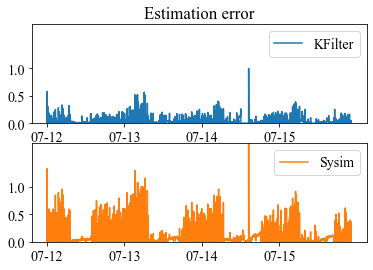

In [424]:
plt.figure(figsize = [6,4])

ax = plt.subplot(2,1,1)
plt.plot(res1[:5660],u'#1f77b4')
ax.set_ylim([0,1.2])
ax.set_title('Estimation error')
ax.legend(['KFilter'])
ax.set_xticks([res1.index[1],res1.index[1441],res1.index[2881],res1.index[1440*3+1]])
ax.set_xticklabels(['07-12','07-13','07-14','07-15'])
ax.set_ylim([0,1.8])
ax.set_yticks([0,0.5,1])
ax = plt.subplot(2,1,2)
plt.plot(res2[:5660],u'#ff7f0e')

ax.legend(['Sysim'])
#ax.set_title('Estimation error')
ax.set_xticks([res1.index[1],res1.index[1441],res1.index[2881],res1.index[1440*3+1]])
ax.set_xticklabels(['07-12','07-13','07-14','07-15'])
ax.set_ylim([0,1.8])
ax.set_yticks([0,0.5,1])

(0, 1.8)

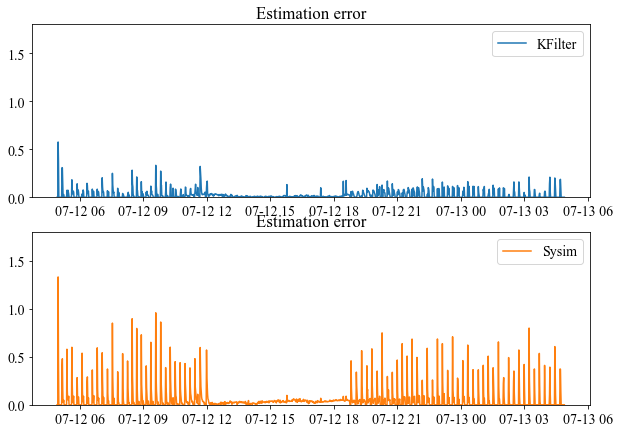

In [425]:
plt.figure(figsize = [10,7])

ax = plt.subplot(2,1,1)
plt.plot(res1[:1440],u'#1f77b4')
ax.set_ylim([0,1.2])
ax.set_title('Estimation error')
ax.legend(['KFilter'])
ax.set_ylim([0,1.8])

ax = plt.subplot(2,1,2)
plt.plot(res2[:1440],u'#ff7f0e')

ax.legend(['Sysim'])
ax.set_title('Estimation error')
ax.set_ylim([0,1.8])

(0, 1)

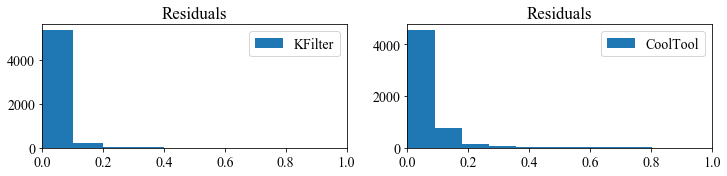

In [426]:
ax = plt.subplot(2,2,3)
plt.hist(res1[:5660])

ax.legend(['KFilter'])
ax.set_title('Residuals')
ax.set_xlim([0,1])
ax = plt.subplot(2,2,4)
plt.hist(res2[:5660],bins = 20)

ax.legend(['CoolTool'])
ax.set_title('Residuals')
ax.set_xlim([0,1])

In [428]:
freq1 = [sum(res1<0.05),sum(res1<0.1)-sum(res1<0.05),sum(res1<0.15)-sum(res1<0.1),sum(res1<0.2)-sum(res1<0.15),2880-sum(res1<0.2)]
freq2 = [sum(res2<0.05),sum(res2<0.1)-sum(res2<0.05),sum(res2<0.15)-sum(res2<0.1),sum(res2<0.2)-sum(res2<0.15),2880-sum(res2<0.2)]

freq1 = [freq/5660 for freq in freq1]
freq2 = [freq/5660 for freq in freq2]

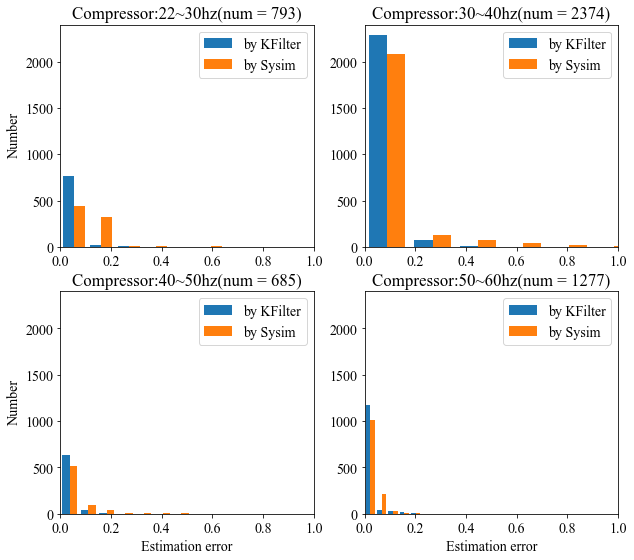

In [431]:
plt.figure(figsize = [10,9])
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.hist((viz_groups[i+1],viz_groups2[i+1]))
    ax.set_title('Compressor:'+ hz_range[i+1]+'hz(num = ' + str(len(viz_groups[i+1])) +')')
    ax.legend(['by KFilter','by Sysim'])
    ax.set_xlim([0,1])
    ax.set_ylim([0,2400])
    if i in [2,3]:
        ax.set_xlabel('Estimation error')
    if i in [0,2]:
        ax.set_ylabel('Number')

### ### 4.1. Kalman Filter Model For power

In [39]:
DF_Org.to_csv(r'.\Data\Amita\power_Result.csv')

In [432]:
DF_Org = pd.read_csv(r'.\Data\Amita\power_Result.csv')

C:\Users\ff9708\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [433]:
on_idx = DF_Org['Actual Comp. Power'] >0
off_idx = DF_Org['Actual Comp. Power'] ==0
transient_idx =  off_idx.shift(1) & on_idx

In [434]:
z_train = np.reshape(np.array(DF_Org['Actual Comp. Power'].iloc[1:1440]),[-1,1])
nrow = len(z_train)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

inp = np.reshape(np.array(DF_Org[['ouPresentCompressorFreq','ouTemperatureOutdoor','iuAirFlowRate','tabTsense0','humidityIndoor.0','const']].iloc[1:1440]),[-1,6,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0


mu0 = [[DF_Org['Actual Comp. Power'].iloc[0]],[DF_Org['Actual Comp. Power'].iloc[0]]]
sigma0 = np.eye(2)
# Function to Calculate Likelihood
def linn_test(par): 
    Phi = np.eye(2)
    Phi[0,0] = par[0]
    Phi[1,1] = 0 # par[1]
    
    cQ = np.eye(2)
    cQ[0,0] =  par[1]
    cQ[1,1] =  par[2]
    
    cR = np.array([[par[3]]])
    
    Ups = np.zeros((2,6))
    Ups[0,0] = par[4]
    Ups[0,1] = par[5]
    Ups[0,2] = par[6]
    Ups[0,3] = par[7]
    Ups[0,4] = par[8]
    Ups[0,5] = par[9]
    
    Ups[1,0] = par[10]
    Ups[1,1] = par[11]
    Ups[1,2] = par[12]
    Ups[1,3] = par[13]
    Ups[1,4] = par[14]
    Ups[1,5] = par[15]

    #print(Ups, inp[0],np.dot(Ups,inp[0]))
    kf = KFilter1_Revised(nrow,z_train,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)
        
    return kf['like']

In [91]:
init_par = [1,.1,.1,.1,1,1,1,1,1,1,1,1,1,1,1,1]
linn_test(init_par)

bnds = ((None, None), (0.01, None),(0.01, None),(0.01, None),(None, None),(None, None),(None, None),(None, None),(None, None),(None, None)
       ,(None, None),(None, None),(None, None),(None, None),(None, None),(None, None))
#bound
res = minimize(linn_test,init_par,method = 'L-BFGS-B',bounds = bnds)

In [96]:
Phi = np.eye(2)
Phi[0,0] = res['x'][0]
Phi[1,1] = 0 #par[1]

cQ = np.eye(2)
cQ[0,0] =  res['x'][1]
cQ[1,1] =  res['x'][2]

cR = np.array([[np.std(DF_Org['Actual Comp. Power'] - DF_Org['Predicted Comp. Power'])]])/2

Ups = np.zeros((2,6))
Ups[0,0] = res['x'][4]
Ups[0,1] = res['x'][5]
Ups[0,2] = res['x'][6]
Ups[0,3] = res['x'][7]
Ups[0,4] = res['x'][8]
Ups[0,5] = res['x'][9]

Ups[1,0] = res['x'][10]
Ups[1,1] = res['x'][11]
Ups[1,2] = res['x'][12]
Ups[1,3] = res['x'][13]
Ups[1,4] = res['x'][14]
Ups[1,5] = res['x'][15]

z_test = np.reshape(np.array(DF_Org['Actual Comp. Power'].iloc[1:2881]),[-1,1])
nrow = len(z_test)
A1 = np.array([[[1,0]]] * nrow)
A2 = np.array([[[0,1]]] * nrow)
A3 = np.array([[[0,0]]] * nrow)

mu0 = [[DF_Org['Actual Comp. Power'].iloc[0]],[DF_Org['Actual Comp. Power'].iloc[0]]]
inp = np.reshape(np.array(DF_Org[['ouPresentCompressorFreq','ouTemperatureOutdoor','iuAirFlowRate','tabTsense0','humidityIndoor.0','const']].iloc[1:2881]),[-1,6,1])
idx1 = np.array(transient_idx.iloc[1:1440])
idx2 = np.array(off_idx.iloc[1:1440])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

#print(Ups, inp[0],np.dot(Ups,inp[0]))
kf = KFilter1_Revised(nrow,z_test,A1,A2,A3,Conds,mu0,sigma0,Phi,Ups,np.array([[0]]),cQ,cR,inp)

In [97]:
idx1 = np.array(transient_idx.iloc[1:2881])
idx2 = np.array(off_idx.iloc[1:2881])
Conds = [1] *nrow
for i,idx in enumerate(idx1):
    if idx:
        Conds[i] = 2
for i,idx in enumerate(idx2):
    if idx:
        Conds[i] = 0

y = [0] *len(Conds)
for i,cond in enumerate(Conds):
    if cond == 1:
        #print(cond)
        y[i] = kf['xf'][i,0]
    elif cond == 2:
        #print(cond)
        y[i] = kf['xf'][i,1]
    else:
        y[i] = 0
        

In [98]:
DF_Org.columns

Index(['Local Time', 'Unnamed: 0', 'Unix Time (s)', 'ouPresentCompressorFreq',
       'ouTemperatureOutdoor', 'iuAirFlowRate', 'tabTsense0',
       'humidityIndoor.0', 'Liq. T.', 'Suc. T.', 'ouCompressorCurrent',
       'ouInputVoltage', 'ouInputCurrent', 'Unnamed: 12', 'OAT Shade T.',
       'iuDAT', 'Unix Time (s).1', 'Local Time.1', 'Dis. P.', 'Liq. P.',
       'Suc. P.', 'NC P.', 'Dis. T.', 'Liq. T..1', 'Suc. T..1', 'Sump T.',
       'OAT Shade T..1', 'OAT Sun T.', 'Cond Bend 2', 'Cond Bend 9',
       'Cond Bend 20', 'Cond Bend 26', 'Cond Bend 58', 'Cond Bend 75',
       'Sat. Dis. T.', 'Sat. Liq. T.', 'Sat. Suc. T.', 'Dis. Super Heat',
       'Liq. Subcool', 'Suc. Super Heat', 'Torque (Input)', 'RPM (FB)',
       'Mech P.', 'Average P.', 'Motor Eff (Calc)', 'CFM (Calc)',
       'Static (Calc)', 'SC_average', 'SH_average', 'Suction', 'Liquid',
       'Comp Count', 'SH Smooth', 'Count', 'Baseline_SC', 'σ', 'Fault_1',
       'Fault_2', 'CFM', 'Persistence1', 'Persistence2', 'Counter'

(-100, 4100)

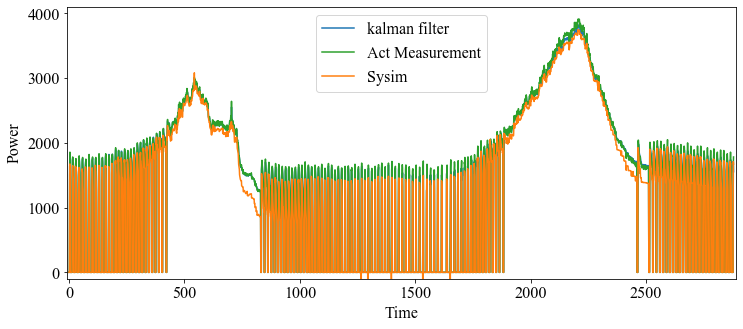

In [87]:
nrow = 2880
ax = plt.subplot(1,1,1)
plt.plot(np.arange(nrow),DF_Org['KF Result'].iloc[1:2881])
plt.plot(np.arange(nrow),DF_Org['Actual Comp. Power'].iloc[1:2881],u'#2ca02c')
plt.plot(np.arange(nrow),DF_Org['Predicted Comp. Power'].iloc[1:2881])
ax.set_xlabel('Time')
ax.set_ylabel('Power')
ax.legend(['kalman filter','Act Measurement','Sysim'])
ax.set_xlim([-10,2891])
ax.set_ylim([-100,4100])

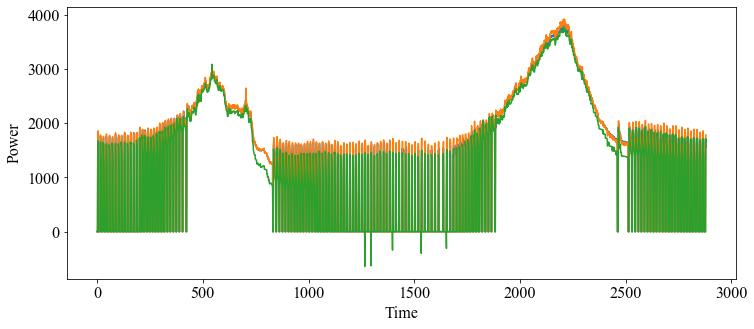

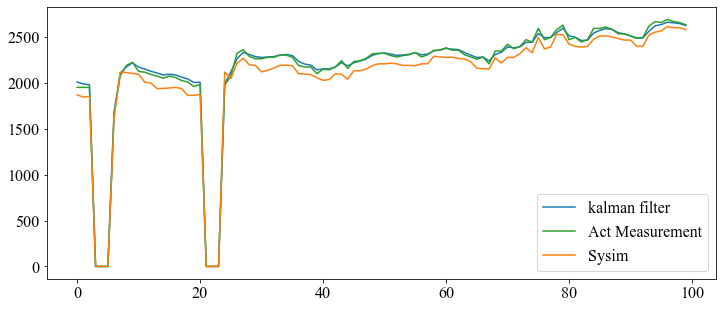

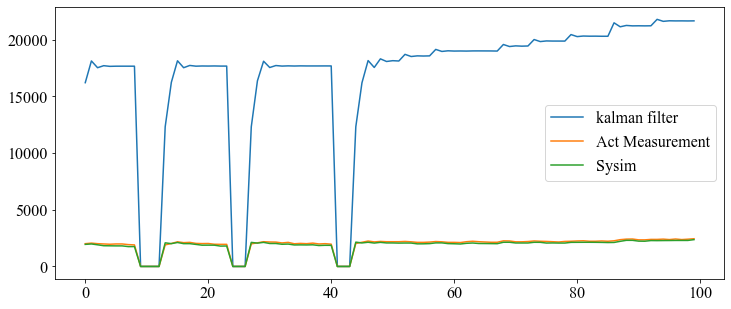

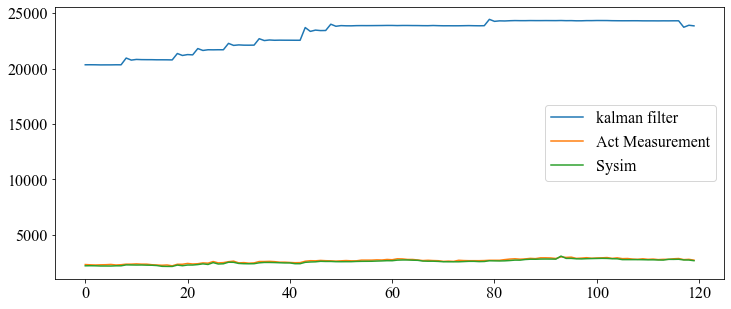

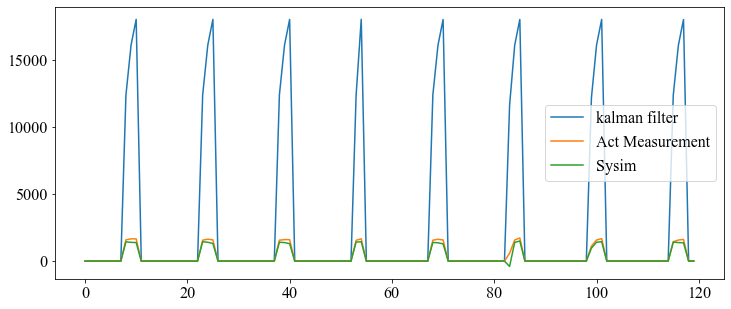

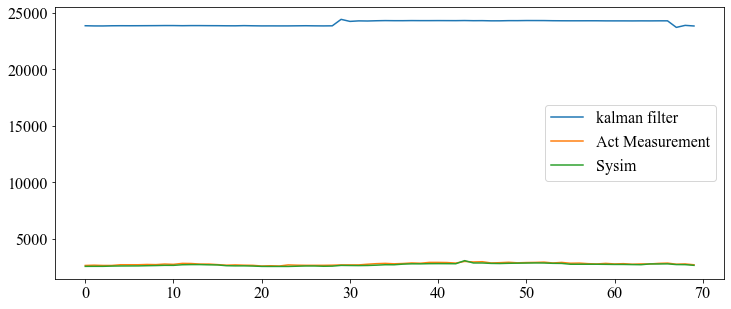

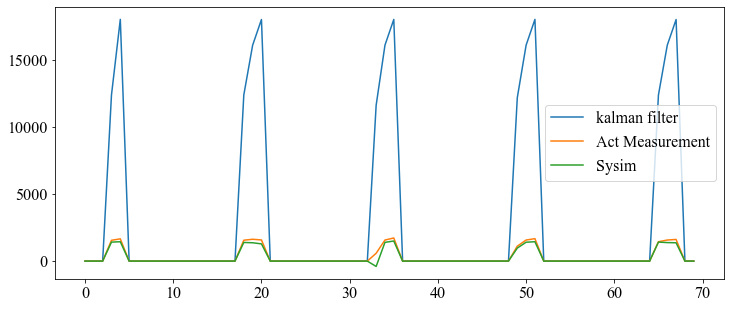

In [89]:

nrow = 2880
ax = plt.subplot(1,1,1)
plt.plot(np.arange(nrow),DF_Org['KF Result'].iloc[1:2881])
plt.plot(np.arange(nrow),DF_Org['Actual Comp. Power'].iloc[1:2881])
plt.plot(np.arange(nrow),DF_Org['Predicted Comp. Power'].iloc[1:2881])
ax.set_xlabel('Time')
ax.set_ylabel('Power')


plt.figure()
ax = plt.subplot()
plt.plot(np.arange(100),DF_Org['KF Result'].iloc[401:501])
plt.plot(np.arange(100),DF_Org['Actual Comp. Power'].iloc[401:501],u'#2ca02c')
plt.plot(np.arange(100),DF_Org['Predicted Comp. Power'].iloc[401:501])
ax.legend(['kalman filter','Act Measurement','Sysim'])


plt.figure()
ax = plt.subplot()
plt.plot(y[1840:1940])
plt.plot(np.arange(100),DF_Org['Actual Comp. Power'].iloc[1841:1941])
plt.plot(np.arange(100),DF_Org['Predicted Comp. Power'].iloc[1841:1941])
ax.legend(['kalman filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[450:570])
plt.plot(np.arange(120),DF_Org['Actual Comp. Power'].iloc[451:571])
plt.plot(np.arange(120),DF_Org['Predicted Comp. Power'].iloc[451:571])
ax.legend(['kalman filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[1450:1570])
plt.plot(np.arange(120),DF_Org['Actual Comp. Power'].iloc[1451:1571])
plt.plot(np.arange(120),DF_Org['Predicted Comp. Power'].iloc[1451:1571])
ax.legend(['kalman filter','Act Measurement','Sysim'])


plt.figure()
ax = plt.subplot()
plt.plot(y[500:570])
plt.plot(np.arange(70),DF_Org['Actual Comp. Power'].iloc[501:571])
plt.plot(np.arange(70),DF_Org['Predicted Comp. Power'].iloc[501:571])
ax.legend(['kalman filter','Act Measurement','Sysim'])

plt.figure()
ax = plt.subplot()
plt.plot(y[1500:1570])
plt.plot(np.arange(70),DF_Org['Actual Comp. Power'].iloc[1501:1571])
plt.plot(np.arange(70),DF_Org['Predicted Comp. Power'].iloc[1501:1571])
ax.legend(['kalman filter','Act Measurement','Sysim'])


In [56]:
# based on Hz Group
hz_under22 = DF_Org["ouPresentCompressorFreq"] <22
hz_22_30 = (DF_Org["ouPresentCompressorFreq"] >= 22) & (DF_Org["ouPresentCompressorFreq"]<30)
hz_30_40 = (DF_Org["ouPresentCompressorFreq"] >= 30) & (DF_Org["ouPresentCompressorFreq"]<40)
hz_40_50 = (DF_Org["ouPresentCompressorFreq"] >= 40) & (DF_Org["ouPresentCompressorFreq"]<50)
hz_50_60 = (DF_Org["ouPresentCompressorFreq"] >= 50) & (DF_Org["ouPresentCompressorFreq"] <60)
hz_above60 = (DF_Org["ouPresentCompressorFreq"] >= 60)
hz_idx = [hz_under22,hz_22_30, hz_30_40,hz_40_50,hz_50_60,hz_above60]

In [57]:
len(y)

10080

In [58]:
DF_Org['KF Result'] = DF_Org['Actual Comp. Power']
DF_Org['KF Result'].iloc[1:2881] = y[:2880]

C:\Users\ff9708\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [84]:
for i in range(DF_Org.shape[0]):
    DF_Org['KF Result'].iloc[i] = float(DF_Org['KF Result'].iloc[i])
        

C:\Users\ff9708\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [85]:
DF_Org['KF Result']

0              0
1              0
2              0
3              0
4        1635.96
          ...   
22818          0
22819          0
22820          0
22821          0
22822          0
Name: KF Result, Length: 22823, dtype: object

In [77]:
for i in range(DF_Org.shape[0]):
    try:
        DF_Org['KF Result'].iloc[i] = float(DF_Org['KF Result'].iloc[i][1:-1])
    except:
        DF_Org['KF Result'].iloc[i] == float(DF_Org['KF Result'].iloc[i])

C:\Users\ff9708\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [78]:
DF_Org['KF Result']

0            0.0
1              0
2              0
3              0
4        1635.96
          ...   
22818          0
22819          0
22820          0
22821          0
22822          0
Name: KF Result, Length: 22823, dtype: object

In [79]:
res1 = DF_Org["Actual Comp. Power"].iloc[1:2881].copy()
res2 = DF_Org["Actual Comp. Power"].iloc[1:2881].copy()

for i in range(2880):
    if DF_Org["Actual Comp. Power"].iloc[i+1] == 0:
        res1.iloc[i] = 0
        res2.iloc[i] = 0
    else:
        res1.iloc[i] = abs(DF_Org["Actual Comp. Power"].iloc[i+1] -DF_Org["KF Result"].iloc[i+1])/DF_Org["Actual Comp. Power"].iloc[i+1]
        res2.iloc[i] = abs(DF_Org["Actual Comp. Power"].iloc[i+1] -DF_Org["Predicted Comp. Power"].iloc[i+1])/DF_Org["Actual Comp. Power"].iloc[i+1]

In [80]:
hz_range = ["<22hz","22~30","30~40","40~50","50~60",">=60"]
viz_groups = [res1[idx_i.iloc[1:2881]] for idx_i in hz_idx]
viz_groups2 = [res2[idx_i[1:2881]] for idx_i in hz_idx]

In [81]:
from sklearn.metrics import r2_score
on_idx = DF_Org["Actual Comp. Power"].iloc[1:2881] >0

print(r2_score(DF_Org["Actual Comp. Power"].iloc[1:2881][on_idx] , DF_Org["Predicted Comp. Power"].iloc[1:2881][on_idx]),
r2_score(DF_Org["Actual Comp. Power"].iloc[1:2881][on_idx] , DF_Org["KF Result"].iloc[1:2881][on_idx]))

0.9129870824218947 0.9922026008528342


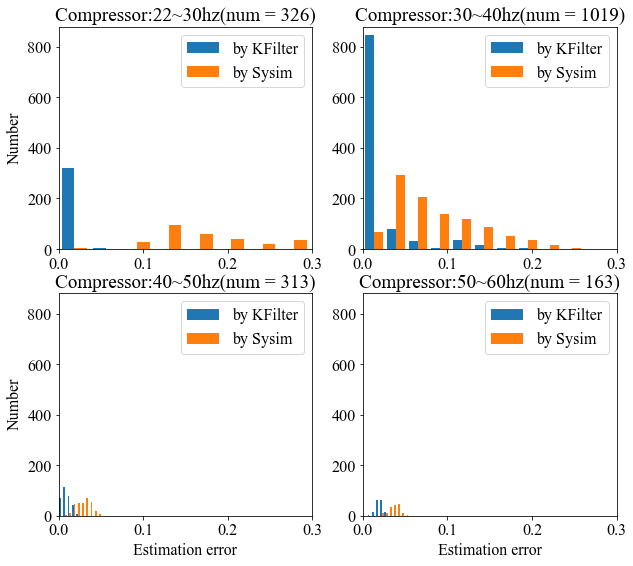

In [82]:
plt.figure(figsize = [10,9])
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.hist((viz_groups[i+1],viz_groups2[i+1]))
    ax.set_title("Compressor:"+hz_range[i+1]+'hz(num = ' + str(len(viz_groups[i+1])) +')')
    ax.legend(['by KFilter','by Sysim'])
    ax.set_xlim([0,0.3])
    ax.set_ylim([0,880])
    if i in [2,3]:
        ax.set_xlabel('Estimation error')
    if i in [0,2]:
        ax.set_ylabel('Number')

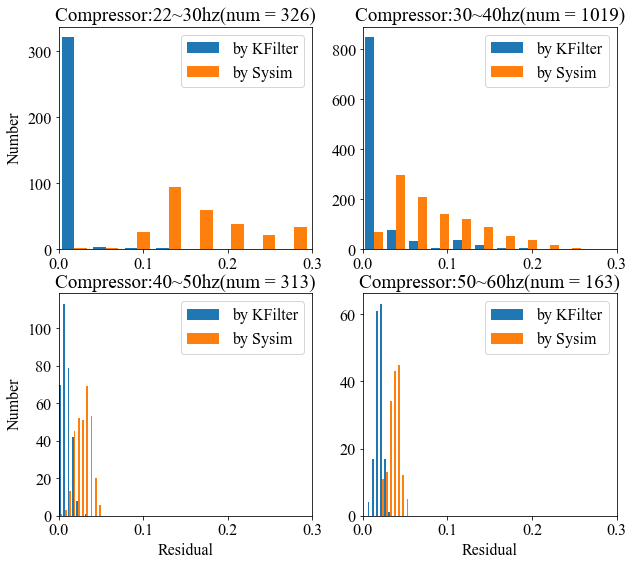

In [92]:
plt.figure(figsize = [10,9])
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    plt.hist((viz_groups[i+1],viz_groups2[i+1]))
    ax.set_title("Compressor:"+hz_range[i+1]+'hz(num = ' + str(len(viz_groups[i+1])) +')')
    ax.legend(['by KFilter','by Sysim'])
    ax.set_xlim([0,0.3])
    if i in [2,3]:
        ax.set_xlabel('Residual')
    if i in [0,2]:
        ax.set_ylabel('Number')

### end